In [ ]:
import json
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import pandas as pd
from IPython import display  # WICHTIG für Jupyter Live-Update
from pandasgui import show
from tqdm import tqdm
import seaborn as sns
from pprint import pprint
import pickle

import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.callbacks import CSVLogger, TensorBoard
from tensorflow.keras.layers import Concatenate, Dense, Lambda, Layer, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

from adapt.instance_based import TrAdaBoostR2
from scikeras.wrappers import KerasRegressor

import importlib
import src.execution
from src.data import NPY
importlib.reload(src.execution)
from src.execution import CNNValidationExecution
from src.execution import WindowSplittingExecution
from src.model import CNN
from src.util import timestamp


Domainadaptation mit TradaBoostR2 aus der Adapt Libary
Erste Version, wenns läuft dann später in den Klassen die einzelnen Methoden ergänzen

---
## **Trainingsdaten erzeugen**
Da die Zuordnung der Datenmengen über die Anzahl der Versuche läuft, wird hier nur der Belchsplit durchgeführt, es wird eine bestimmte Anzahl an Blechen gewählt. 

- Trainingsdaten aus den Simulationsdaten werden wie gehabt erzeugt
- Target Domain Daten werden aus den Raldaten erzeugt.   

Simulationsdaten: Blechsplit

In [ ]:
#DATA: str = "assets/synthetic-data.csv"
DATA: str = "assets/data/stationary_data_250402/sim_data_preprocessed_offset_multiplitiv.csv"
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.2
BATCH_SPLIT: bool = True # Blechsplit bei True 
BATCHSIZE: int = 326 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "." # Decimal separator of the csv file

WindowSplittingExecution.execute(DATA, 
                                 BATCH_SPLIT, 
                                 VALIDATION_SPLIT, 
                                 TEST_SIZE, 
                                 SEED, 
                                 BATCHSIZE, 
                                 INTERPOLATION, 
                                 WINDOWSIZE, 
                                 SEP, 
                                 DECIMAL)



In [ ]:
#DATA: str = "assets/synthetic-data.csv"
DATA: str = "assets/data/stationary_data_250402/sim_data_preprocessed.csv"
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.2
BATCH_SPLIT: bool = True # Blechsplit bei True 
BATCHSIZE: int = 326 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "." # Decimal separator of the csv file

WindowSplittingExecution.execute(DATA, 
                                 BATCH_SPLIT, 
                                 VALIDATION_SPLIT, 
                                 TEST_SIZE, 
                                 SEED, 
                                 BATCHSIZE, 
                                 INTERPOLATION, 
                                 WINDOWSIZE, 
                                 SEP, 
                                 DECIMAL)

Realdaten Blechsplit (`Train_Test_Split = 2`):
- Die Daten trennen in A % Trainingsdaten für den TradaBoostR2 und B % Testdaten
--> Solche Auftielung mti den Vorhandneen Methoden leichter umzusetzen als über exakte Anzahl der Bleche
- Die Domain Adaptation wird auf dem A % Testdaten durchgeführt
- Testen erfolgt auf dem Testdatensatz
- Die Größenverhältnisse der Datensätze werden über die Variable  `size` eingestellt
- `size = 0.9` so werden 10 % der Bleche in das TradaBoost DaomainAdaptaion gegeben, die restlichen 90 % der Daten werden zum Kontrollieren verwndet  

In [ ]:
DATA: str = "assets/data/real-data.csv"
#DATA: str = ""
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.99
BATCH_SPLIT: bool = True
BATCHSIZE: int = 1800 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "," # Decimal separator of the csv file

WindowSplittingExecution.execute(DATA, 
                                 BATCH_SPLIT, 
                                 VALIDATION_SPLIT, 
                                 TEST_SIZE, 
                                 SEED, 
                                 BATCHSIZE, 
                                 INTERPOLATION, 
                                 WINDOWSIZE, 
                                 SEP, 
                                 DECIMAL)



## **Splitten der Datensätze - K Fold Crossvalidation**
 Splitte auf den Inputdaten und dannin den Windo Zeug da so einfacher!!!

In [ ]:
DATA: str = "assets/data/real-data.csv"
#DATA: str = ""
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.2
BATCH_SPLIT: bool = True
BATCHSIZE: int = 1800 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "," # Decimal separator of the csv file

WindowSplittingExecution.execute(DATA, 
                                 BATCH_SPLIT, 
                                 VALIDATION_SPLIT, 
                                 TEST_SIZE, 
                                 SEED, 
                                 BATCHSIZE, 
                                 INTERPOLATION, 
                                 WINDOWSIZE, 
                                 SEP, 
                                 DECIMAL)

In [ ]:
# Konkardinieren aller Daten zu einem Datensatz
dateipfad="build\\window_split\\real-data\\Realdaten_Konkardiniert\\1744197670\\"
input_data = []
output_data=[]
for datei in os.listdir(dateipfad):
    if datei.endswith("scaled.npy"):
        pfad = os.path.join(dateipfad, datei)
        array=NPY.from_file(pfad).array
        print(f"array shape: {array.shape}")
        if datei.startswith("x"):
            input_data.extend(array)
        elif datei.startswith("y"):
            output_data.extend(array)
        print(f"Datei {datei} geladen")
      
print(f"Anzahl der Input-Daten: {len(input_data)}")
print(f"Anzahl der Output-Daten: {len(output_data)}")
dataset = [{"input": xi, "output": yi} for xi, yi in zip(input_data, output_data)]
dataset_pd = pd.DataFrame(dataset)
unique = []
for out in dataset_pd["output"]:
    if not any(np.array_equal(out, u) for u in unique):
        unique.append(out)

print(f"Anzahl verschiedener Outputs: {len(unique)}")


Methode von Davi

In [ ]:
def validation_data_Mix(N: int, anteil):
    for seed in random.randint(0, 32000, N):
        DATA: str = "assets/data/real-data.csv"
        VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
        TEST_SIZE: float = (100-anteil)/100
        BATCH_SPLIT: bool = True
        BATCHSIZE: int = 1800 # real-data: 1800, synthetic-data: 326
        SEED: int = seed # Seed for random state -> Split with same seed and data will always result in the same split
        INTERPOLATION: bool = False
        WINDOWSIZE: int = 10
        SEP: str = ";" # Separator of the csv file
        DECIMAL: str = "," # Decimal separator of the csv file
        
        WindowSplittingExecution.execute_with_scaler(DATA, 
                                        BATCH_SPLIT, 
                                        VALIDATION_SPLIT, 
                                        TEST_SIZE, 
                                        SEED, 
                                        BATCHSIZE, 
                                        INTERPOLATION, 
                                        WINDOWSIZE, 
                                        SEP, 
                                        DECIMAL)



In [ ]:
# Erzeugen von 10 Datensätzen mit jeweils 5% Trainingsdaten 
validation_data_Mix(N=15, anteil=15)

Klären wie viele Daten in mehreren Dateien vorkommen, um Lekage zu vermeiden. 
Weil halt, ansonsten in Pipeline rum basteln und K Fold machen

In [ ]:
import os
import numpy as np
import hashlib
from collections import Counter, defaultdict

def compute_sample_md5_list(arr):
    """
    Gegeben ein Array arr mit Shape (a, b, c) berechnet diese Funktion
    für jeden Sample (Matrix mit Shape (b,c)) den md5-Hash (als Hex-Digest)
    und liefert eine Liste der Hashwerte (in der gleichen Reihenfolge wie die Samples).
    """
    hashes = []
    for i in range(arr.shape[0]):
        # Berechne den md5-Hash des Bytestrings der Matrix
        h = hashlib.md5(arr[i].tobytes()).hexdigest()
        hashes.append(h)
    return hashes

def get_all_npy_files(base_dir, target_filename="x-train-scaled.npy"):
    """
    Sucht rekursiv im base_dir nach Dateien mit dem Namen target_filename.
    """
    file_paths = []
    for root, dirs, files in os.walk(base_dir):
        if target_filename in files:
            file_paths.append(os.path.join(root, target_filename))
    return file_paths

# Basisverzeichnis anpassen
base_dir = "build\\window_split\\real-data\\Realdaten_20Prozent_Random"  # <-- hier Pfad eintragen

# 1. Alle Dateien finden
file_paths = get_all_npy_files(base_dir)

# Dictionaries zur Speicherung:
#  - file_hash_lists: für jede Datei die Liste (länge a) der Sample-Hashes (in der Originalreihenfolge)
#  - file_counters: für jede Datei den Counter der Hashwerte (Häufigkeiten innerhalb der Datei)
file_hash_lists = {}
file_counters = {}

for fp in file_paths:
    arr = np.load(fp)  # Annahme: arr.shape = (a, b, c)
    hashes = compute_sample_md5_list(arr)
    file_hash_lists[fp] = hashes
    file_counters[fp] = Counter(hashes)

# 2. Globalen Counter über alle Dateien erstellen
global_counter = Counter()
for cnt in file_counters.values():
    global_counter.update(cnt)

# 3. Für jede Datei – für jedes Sample – ermitteln, wie oft der gleiche Sample in anderen Dateien vorkommt.
#    Das Ergebnis: für jede Datei eine Liste (Länge a) mit der "Anzahl Vorkommen in anderen Dateien".
results = {}
for fp, hash_list in file_hash_lists.items():
    # Hole den Counter für diese Datei
    cnt = file_counters[fp]
    # Für jeden Sample (bzw. seinen Hash) berechnen:
    # global_count[h] - (wie oft h in dieser Datei vorkommt)
    # Dies ergibt, wie oft h in allen Dateien außer dieser vorkommt.
    occ_list = [global_counter[h] - cnt[h] for h in hash_list]
    results[fp] = occ_list

# Beispiel: Ausgabe der Summen und Durchschnittswerte pro Datei
for fp, occ_list in results.items():
    total_occurrences = sum(occ_list)
    avg_occurrences = total_occurrences / len(occ_list)
    print(f"Datei {fp}:")
    print(f"  Insgesamt kommen alle Samples in anderen Dateien insgesamt {total_occurrences} Mal vor.")
    print(f"  Im Schnitt also {avg_occurrences:.2f} Mal pro Sample.")


## **Kontrolle der Verteilungen**
Verglichen werden die Verteilungen der Inputs und Outputs vor dem Skalierung und danach
Problem: Die Daten der Targetdomain und der Sourcdomain werdne mit unterschiedlichen Scalern skaliert, die skalierten Daten leigen immer übereinander, da mit min max scaliert wird 

In [ ]:
dateipfad_femDaten="build\\window_split\\sim_data_preprocessed\\1743966345"
dateipfad_realDaten="build\\window_split\\experiment-data-subset\\1743966491"	

def plotAllHistOfFIle(file_name):
    # Lade die Daten aus beiden Ordnern
    fem_path = os.path.join(dateipfad_femDaten, file_name)
    real_path = os.path.join(dateipfad_realDaten, file_name)

    # Daten als numpy-Array laden
    fem_data = np.load(fem_path)
    real_data = np.load(real_path)
    fem_data = fem_data.reshape(-1, fem_data.shape[2])  # Shape: (287560, 11)
    real_data = real_data.reshape(-1, real_data.shape[2])  # Shape: (254180, 11)
    # Anzahl der Features (Spalten)
    num_features = fem_data.shape[1]
    print(fem_data.shape)
    print(real_data.shape)
    bins = 50  # Anzahl der Bins für die Histogramme


    # Anzahl der Spalten pro Zeile
    cols = 4
    rows = (num_features + cols - 1) // cols  # Rundet auf, falls nicht durch 4 teilbar

    # Plots erstellen
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()  # 2D Array in 1D umwandeln für einfachere Iteration

    for i in range(num_features):
        ax = axes[i]
        sns.histplot(fem_data[:, i], bins=bins, kde=True, ax=axes[i], color="blue", label="Simulation", stat="density", alpha=0.6)
        sns.histplot(real_data[:, i], bins=bins, kde=True, ax=axes[i], color="orange", label="Realdaten", stat="density", alpha=0.6)
        ax.set_title(f"Feature {i+1}")
        ax.set_xlabel("Wert")
        ax.set_ylabel("Dichte")
        ax.legend()

    # Leere Subplots deaktivieren, falls es weniger als 4*n Features gibt
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Datei laden



In [ ]:
plotAllHistOfFIle("x-train-scaled.npy")
plotAllHistOfFIle("y-train-scaled.npy")
plotAllHistOfFIle("y-train.npy")

---
## **DeepCoral Daten**

ACHTUNG: Das DeepCORAL für TrAdaBoostR2 ist bisschen unstrukturiert, am Besten in Data Analysis nochmal anpassen und die Split Funktion von Corvin neu aufsetzen  

- assets/data/stationary_data_250402/sim_data_preprocessed.csv ist gleich zu \build\Finale_Data\stationary_data_unverarbeitet\sim_data_preprocessed.csv
- ->Bereits in TradaBoostR2 getestet
- Datensatz -> Immer 20% der Realdaten, also dann 50% davon sind 10% der Gesamtdaten!!!
- -> Datensätze sollten gleich sein, aber besser die aus dem jeweiligen Ordner nehmen
- sim_data_CORAL... sind nur die Kraftdaten skaliert, erneutes skalieren dürfte bei Standard scaler nichts machen
- Datensatz ...used ist komplett in Alignement eingegangen
- ->Validierung über Datensatz ...not-used
- ->...-used sind Trainingsdaten, Validieurngsdaten dürfen NICHT aus diesem Datensatz kommen
- Modell 

Plan: Erst mal nur CORAL Daten nehmen und damit TradaBostR2 Trainieren
- experiment-data-subset_used.csv nehmen davon 99% dann also ~20% der Realdaten
- Validierungsdaten und Testdaten aus experiment-data-subset_not_used.csv



In [ ]:
#realdata_used="build\\Finale_Data\\stationary_data_offset_labeladaption_Coral\\experiment-data-subset_used.csv"
sim_data_CORAL="build\\Finale_Data\\stationary_data_offset_labeladaption_Coral\\sim_data_CORAL_preprocessed_offset_labels.csv"
DATA: str = sim_data_CORAL
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.2
BATCH_SPLIT: bool = True
BATCHSIZE: int = 326 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "." # Decimal separator of the csv file

WindowSplittingExecution.execute_with_scaler(DATA, 
                                BATCH_SPLIT, 
                                VALIDATION_SPLIT, 
                                TEST_SIZE, 
                                SEED, 
                                BATCHSIZE, 
                                INTERPOLATION, 
                                WINDOWSIZE, 
                                SEP, 
                                DECIMAL)


In [ ]:
realdata_NOT_used="build\\Finale_Data\\stationary_data_offset_labeladaption_Coral\\experiment-data-subset_not_used.csv"
DATA: str = realdata_NOT_used
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.99
BATCH_SPLIT: bool = True
BATCHSIZE: int = 1800 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "," # Decimal separator of the csv file

WindowSplittingExecution.execute_with_scaler(DATA, 
                                BATCH_SPLIT, 
                                VALIDATION_SPLIT, 
                                TEST_SIZE, 
                                SEED, 
                                BATCHSIZE, 
                                INTERPOLATION, 
                                WINDOWSIZE, 
                                SEP, 
                                DECIMAL)


In [ ]:
#Alle Dateien Finden und Bearbeitne für TradaBoostR2
def finde_dateipfade(super_ordner):
    not_used_pfade = []
    used_pfade = []
    sim_data_pfade=[]

    for root, dirs, files in os.walk(super_ordner):
        if 'experiment-data-subset_not_used.csv' in files:
            not_used_pfade.append(os.path.join(root, 'experiment-data-subset_not_used.csv'))
        if 'experiment-data-subset_used.csv' in files:
            used_pfade.append(os.path.join(root, 'experiment-data-subset_used.csv'))
        if 'sim_data_CORAL_preprocessed_offset.csv' in files:
            sim_data_pfade.append(os.path.join(root, 'sim_data_CORAL_preprocessed_offset.csv'))

    return not_used_pfade, used_pfade, sim_data_pfade

super_ordner = "build\\stationary_data_coral_offset"  # <- hier deinen Pfad anpassen
not_used_liste, used_liste, sim_data_pfade = finde_dateipfade(super_ordner)
print("Not Used Dateien:")
for pfad in not_used_liste:
    print(pfad)

print("\nUsed Dateien:")
for pfad in used_liste:
    print(pfad)

print("\nSim Dateien:")
for pfad in sim_data_pfade:
    print(pfad)


In [ ]:
#Simulationsdaten CORAL 1 bis 5
for dateipfad in sim_data_pfade:
    sim_data_CORAL=dateipfad
    DATA: str = sim_data_CORAL
    VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
    TEST_SIZE: float = 0.2
    BATCH_SPLIT: bool = True
    BATCHSIZE: int = 326 # real-data: 1800, synthetic-data: 326
    SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
    INTERPOLATION: bool = False
    WINDOWSIZE: int = 10
    SEP: str = ";" # Separator of the csv file
    DECIMAL: str = "." # Decimal separator of the csv file

    WindowSplittingExecution.execute_with_scaler(DATA, 
                                    BATCH_SPLIT, 
                                    VALIDATION_SPLIT, 
                                    TEST_SIZE, 
                                    SEED, 
                                    BATCHSIZE, 
                                    INTERPOLATION, 
                                    WINDOWSIZE, 
                                    SEP, 
                                    DECIMAL)

In [ ]:
#Experiment Data für CORAL subset_used
for datei_pfad in used_liste:
    DATA: str = datei_pfad
    VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
    TEST_SIZE: float = 0.07
    BATCH_SPLIT: bool = True
    BATCHSIZE: int = 1800 # real-data: 1800, synthetic-data: 326
    SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
    INTERPOLATION: bool = False
    WINDOWSIZE: int = 10
    SEP: str = ";" # Separator of the csv file
    DECIMAL: str = "," # Decimal separator of the csv file

    WindowSplittingExecution.execute_with_scaler(DATA, 
                                    BATCH_SPLIT, 
                                    VALIDATION_SPLIT, 
                                    TEST_SIZE, 
                                    SEED, 
                                    BATCHSIZE, 
                                    INTERPOLATION, 
                                    WINDOWSIZE, 
                                    SEP, 
                                    DECIMAL)


In [ ]:
#Experiment Data für CORAL not_used_liste
for datei_pfad in not_used_liste:
    DATA: str = datei_pfad
    VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
    TEST_SIZE: float = 0.99
    BATCH_SPLIT: bool = True
    BATCHSIZE: int = 1800 # real-data: 1800, synthetic-data: 326
    SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
    INTERPOLATION: bool = False
    WINDOWSIZE: int = 10
    SEP: str = ";" # Separator of the csv file
    DECIMAL: str = "," # Decimal separator of the csv file

    WindowSplittingExecution.execute_with_scaler(DATA, 
                                    BATCH_SPLIT, 
                                    VALIDATION_SPLIT, 
                                    TEST_SIZE, 
                                    SEED, 
                                    BATCHSIZE, 
                                    INTERPOLATION, 
                                    WINDOWSIZE, 
                                    SEP, 
                                    DECIMAL)


"build\window_split\experiment-data-subset_used\1744565138" ->TEST_SIZE: float = 0.07
->Trainingsdatensatz für TradaBoostR2 Realdaten

Scaler existieren nun, diese auf die restlichen Daten anwenden

->Restliche Daten: Erzeugen mit WindowSplittingExecution 

Daten Not Used in Training:
build\window_split\experiment-data-subset_not_used\1744565885 -> TEST_SIZE: float = 0.99

->Diese Scaler und scalierten Daten sind Unbrauchbar!!!

Vorgehen:
1. WRONGx-test-scaled.npy und WRONGx-validate-scaled.npy mit THIS_scalers_features.pkl zurückscalieren
2. x-test.npy und x-validate.npy erzeugen
3. x-test.npy und x-validate.npy mit dem Scaler aus experiment-data-subset_used\1744565138 scalieren und in build\window_split\experiment-data-subset_used\1744565138 abspeichern als x-test-scaled.npy x-validate-scaled.npy
4. y-test.npy und y-validate.npy mit dem Scaler aus experiment-data-subset_used\1744565138 scalieren und in build\window_split\experiment-data-subset_used\1744565138 abspeichern als y-test-scaled.npy y-validate-scaled.npy

In [ ]:
# Rückskalieren
def rückskalieren_WRONG_Daten(ordner_pfad):
    """
    ACHTUNG: Überschriebt ohne Namensänderung!!!!!!
    Lädt die gruppierten Scaler aus 'scalers_features.pkl' im angegebenen Ordner,
    skaliert die Dateien 'x-test-scaled.npy' und 'x-validate-scaled.npy' gruppenweise zurück 
    und speichert sie als 'x-test.npy' und 'x-validate.npy' im gleichen Ordner.

    Parameter:
        ordner_pfad (str): Pfad zum Ordner, der die Dateien enthält.
        group_features (list of list of int): Featuregruppen entsprechend der Scaler-Reihenfolge.
    """

    # Scaler laden
    scaler_path = os.path.join(ordner_pfad, "scalers_features.pkl")
    with open(scaler_path, 'rb') as f:
        scalers_features = pickle.load(f)

    # Skalierte Test- und Validierungsdaten laden
    x_test_scaled_path = os.path.join(ordner_pfad, "x-test-scaled.npy")
    x_validate_scaled_path = os.path.join(ordner_pfad, "x-validate-scaled.npy")

    x_test_scaled = np.load(x_test_scaled_path)
    x_validate_scaled = np.load(x_validate_scaled_path)

    # Rückskalieren gruppenweise
    print(scalers_features[0].n_features_in_)
    print(x_test_scaled[:,:, [0, 1, 2, 3, 4, 5, 6, 7]].shape)
    group_features = [[0, 1, 2, 3, 4, 5, 6, 7], [8, 9], [10]]
    x_test_unscaled = np.zeros_like(x_test_scaled)
    x_validation_unscaled = np.zeros_like(x_validate_scaled)
    
    # Rückskalieren für jede Gruppe
    for x_unscaled, x_scaled in zip([x_test_unscaled, x_validation_unscaled], [x_test_scaled, x_validate_scaled]):
        num_samples, num_timesteps, _ = x_scaled.shape
        print(f"num_samples: {num_samples}")
        print(f"num_timesteps: {num_timesteps}")
        for scaler, feature_indices in zip(scalers_features, group_features):
            print(feature_indices)
            subset_scaled = x_scaled[:, :, feature_indices]
            subset_scaled_2d = subset_scaled.reshape(-1, len(feature_indices))
            subset_unscaled_2d = scaler.inverse_transform(subset_scaled_2d)
            subset_unscaled = subset_unscaled_2d.reshape(num_samples, num_timesteps, len(feature_indices))
            x_unscaled[:, :, feature_indices] = subset_unscaled
            

    # Zurückgespeicherte Dateien
    x_test_output_path = os.path.join(ordner_pfad, "x-test.npy")
    x_validate_output_path = os.path.join(ordner_pfad, "x-validate.npy")

    np.save(x_test_output_path, x_test_unscaled)
    np.save(x_validate_output_path, x_validation_unscaled)

    print(f"Zurückskalierte Dateien gespeichert:\n- {x_test_output_path}\n- {x_validate_output_path}")


In [ ]:
#Skalieren in Zielscaler
def scale_x_values(folder_training_scaler, folder_test_val_data_unscaled):
    """
    Skaliert Test- und Validierungsdaten gruppenweise mit gespeicherten Scalern 
    und speichert die skalierten und unskalierten Daten im Trainings-Ordner.

    Parameter:
        folder_training_scaler (str): Ordnerpfad, in dem scalers_features.pkl und scalers_labels.pkl liegen.
        folder_test_val_data_unscaled (str): Ordnerpfad mit unskalierten x- und y-Daten (.npy-Dateien).
    """

    # --- Scaler laden ---
    scalers_features = load_scaler(os.path.join(folder_training_scaler, "scalers_features.pkl"))
    scalers_labels = load_scaler(os.path.join(folder_training_scaler, "scalers_labels.pkl"))

    # --- Unskalierte Daten laden ---
    x_test = np.load(os.path.join(folder_test_val_data_unscaled, "x-test.npy"))
    x_validate = np.load(os.path.join(folder_test_val_data_unscaled, "x-validate.npy"))
    y_test = np.array(np.load(os.path.join(folder_test_val_data_unscaled, "y-test.npy"),allow_pickle=True))
    y_validate = np.array(np.load(os.path.join(folder_test_val_data_unscaled, "y-validate.npy"),allow_pickle=True))
    
    # --- Feature-Gruppen-Definition ---
    group_features = [[0, 1, 2, 3, 4, 5, 6, 7], [8, 9], [10]]
    group_labels = [[0, 1], [2]]

    # --- Skaliere x-Daten ---
    x_test_scaled = scale_groupwise(x_test, scalers_features, group_features)
    x_validate_scaled = scale_groupwise(x_validate, scalers_features, group_features)
    
    # --- Skaliere y-Daten ---
    y_test_scaled = scale_groupwise(y_test, scalers_labels, group_labels)
    y_validate_scaled = scale_groupwise(y_validate, scalers_labels, group_labels)
    
    # --- Speichern ---
    save_scaled_data(folder_training_scaler, "x-test", x_test, x_test_scaled)
    save_scaled_data(folder_training_scaler, "x-validate", x_validate, x_validate_scaled)
    save_scaled_data(folder_training_scaler, "y-test", y_test, y_test_scaled)
    save_scaled_data(folder_training_scaler, "y-validate", y_validate, y_validate_scaled)

    print("✅ Skaliert und gespeichert.")

# Hilfsfunktion: Scaler laden
def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Hilfsfunktion: Gruppiertes Skalieren
def scale_groupwise(data, scalers, groups):
    """
    Skaliert gruppenweise Daten mit einer Liste von Scalers.

    Parameter:
        data (np.ndarray): Eingabedaten (mindestens 2D oder 3D für x-Daten)
        scalers (list): Liste der Scaler-Objekte
        groups (list of list): Liste der Gruppen-Feature-Indices
        
    Rückgabe:
        np.ndarray: Skalierte Daten in gleicher Form wie Input
    """
    scaled_data = np.zeros_like(data)

    if data.ndim == 3:  # z.B. (samples, timesteps, features)
        print("Hierrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr")
        num_samples, num_timesteps, _ = data.shape
        for scaler, feature_indices in zip(scalers, groups):
            subset = data[:, :, feature_indices]
            subset_2d = subset.reshape(-1, len(feature_indices))
            subset_scaled_2d = scaler.transform(subset_2d)
            subset_scaled = subset_scaled_2d.reshape(num_samples, num_timesteps, len(feature_indices))
            scaled_data[:, :, feature_indices] = subset_scaled

    elif data.ndim == 2:  # z.B. (samples, features)
        num_samples, _ = data.shape
        for scaler, feature_indices in zip(scalers, groups):
            subset = data[:, feature_indices]
            subset_scaled = scaler.transform(subset)
            scaled_data[:, feature_indices] = subset_scaled

    else:
        raise ValueError("Unsupported data shape. Expected 2D or 3D array.")

    return scaled_data

# Hilfsfunktion: Speichern von skalierten und unskalierten Daten
def save_scaled_data(folder, base_filename, unscaled_data, scaled_data):
    print(f"unscaled_data in: {os.path.join(folder, f"{base_filename}.npy")}")
    print(f"scaled_data in : {os.path.join(folder, f"{base_filename}-scaled.npy")}")
    np.save(os.path.join(folder, f"{base_filename}.npy"), unscaled_data)
    np.save(os.path.join(folder, f"{base_filename}-scaled.npy"), scaled_data)


ACHTUNG: Auskommentiert weil Method ezeug Überschreiben kann

In [ ]:
# Erstellen der unscalierten daten x-test und x-validate der experiment-data-subset_not_used Daten
#for root, dirs, files in os.walk("build\\window_split\\experiment-data-subset_not_used"):
    #if 'metadata.json' in files: # Sonst Fehler um 1
        # Zurückscalieren der daten
       # rückskalieren_WRONG_Daten(os.path.join(root))

Harter Code notwendig wegen zuordnung von Ordnern mit Daten und den Scalern

In [ ]:
'''
scale_x_values(folder_training_scaler="build\\window_split\\experiment-data-subset_used\\1744580192",
                folder_test_val_data_unscaled="build\\window_split\\experiment-data-subset_not_used\\1744580616")

scale_x_values(folder_training_scaler="build\\window_split\\experiment-data-subset_used\\1744580196",
                folder_test_val_data_unscaled="build\\window_split\\experiment-data-subset_not_used\\1744580632")

scale_x_values(folder_training_scaler="build\\window_split\\experiment-data-subset_used\\1744580201",
                folder_test_val_data_unscaled="build\\window_split\\experiment-data-subset_not_used\\1744580652")

scale_x_values(folder_training_scaler="build\\window_split\\experiment-data-subset_used\\1744580205",
                folder_test_val_data_unscaled="build\\window_split\\experiment-data-subset_not_used\\1744580674")

scale_x_values(folder_training_scaler="build\\window_split\\experiment-data-subset_used\\1744580210",
                folder_test_val_data_unscaled="build\\window_split\\experiment-data-subset_not_used\\1744580698")
'''

In [ ]:
#rückskalieren_WRONG_Daten("build\\window_split\\experiment-data-subset_not_used\\1744565885")
tmp=np.array(np.load("build\\window_split\\experiment-data-subset_not_used\\1744565885\\y-test.npy",allow_pickle=True))
print(tmp.shape)

In [ ]:
scale_x_values(folder_training_scaler="build\\window_split\\experiment-data-subset_used\\1744565138",
                folder_test_val_data_unscaled="build\\window_split\\experiment-data-subset_not_used\\1744565885")

---
### **Tuning des TradaBoostR2 geeigneten Modells**
- TradaBoostR2 erlaubt nur einen Putput, hier ein Array mit 3 Elementen 
- Tuning muss überarbeitete werden, da Validationloss für Modelle mit drei outputs nicht geeignet ist


In [ ]:
from src.execution import CNNTuningExecution
SPLITTED_DATA_FOLDER = "build\\window_split\\sim_data_preprocessed\\1743966827\\"
CNNTuningExecution.execute_tuning_singleOutput(SPLITTED_DATA_FOLDER,max_trials=10,train_on_scled_labels=True)

---
## **TradaBoostR2**
- Early stopping und Valiadation enthalten
- Modell umschrieben mit neuer Sparse Layer, eine Layer fasst die Outputs von zuvor zusammen 
    - Die Letze Layer wird nun nur sparse besetzt und ist nicht trainierbar
    - Outputs werden direkt in diese Layer weitergegeben, ist so ne Eigenheit von TradaBoostR2, kann nur auf einem Output arbeiten

In [ ]:
@register_keras_serializable(package="custom_layers")
class SparseStackLayer(Layer):
    def __init__(self, **kwargs):
        super(SparseStackLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Kombiniert Liste von Tensoren (z. B. [batch, 1], [batch, 1], [batch, 1])
        # zu einem Tensor mit Shape (batch, 3)
        return tf.concat(inputs, axis=-1)
class LivePlotCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = {"loss": [], "val_loss": []}
        #self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        self.history["loss"].append(logs.get("loss", 0))
        self.history["val_loss"].append(logs.get("val_loss", 0))

    def on_train_end(self, logs=None):
        logs = logs or {}
        self.history["loss"].append(logs.get("loss", 0))
        self.history["val_loss"].append(logs.get("val_loss", 0))

        plt.figure(figsize=(6, 4))
        epochs = list(range(1, len(self.history["loss"]) + 1))

        plt.plot(epochs, self.history["loss"], label="Trainingsverlust (Loss)", color="blue", marker="o")
        plt.plot(epochs, self.history["val_loss"], label="Validierungsverlust (Loss)", color="red", linestyle="dashed", marker="o")

        plt.xlabel("Epoche")
        plt.ylabel("Loss")
        plt.title("Training vs. Validierung")
        plt.grid(True)
        plt.legend()
        display.display(plt.gcf())

def domainAdapt_tradaBoostR2_noProcessDoku(cnn_wrapped,n_estimators_tradaBoostR2,learning_rate_tradaBoostR2,
                                           X_source_scaled,y_source_scaled,
                                           X_target_scaled,y_target_scaled,
                                           X_source_scaled_Test,y_source_scaled_Test,
                                           save_folder, save_filename                    
                                           ):
    print("Keine Prozessdokumentation der einzelnen Iterationen")
    #Dim Reduktion, weil halt
    y_source_scaled=np.squeeze(y_source_scaled)
    y_target_scaled=np.squeeze(y_target_scaled)

    tradaboost_model = TrAdaBoostR2(
        estimator=cnn_wrapped,  # CNN als Basis-Regressor
        n_estimators=n_estimators_tradaBoostR2,  # Anzahl der Boosting-Iterationen
        verbose=1,
        lr=learning_rate_tradaBoostR2,  # Lernrate für den Boosting-Prozess
        Xt=X_target_scaled,  # Ziel-Domain-Daten (Realdaten)
        yt=y_target_scaled,  # Ziel-Domain-Zielwerte (Realdaten)
    )

    tradaboost_model.fit(X_source_scaled, y_source_scaled,validation_data=(X_source_scaled_Test,y_source_scaled_Test)) # TODO Realdaten in Validieurn gaufnehmen
    
    trained_model = tradaboost_model.estimators_[-1]  # Letzter trainierter Estimator
    trained_model.model_.save(os.path.join(save_folder, f"{save_filename}.h5"))
   
def domainAdapt_tradaBoostR2_earlystopping(cnn_wrapped,n_estimators_tradaBoostR2,learning_rate_tradaBoostR2,
                                           X_source_scaled,y_source_scaled,
                                           X_target_scaled,y_target_scaled,
                                           X_source_scaled_Test,y_source_scaled_Test,
                                           save_folder, save_filename                    
                                           ):
    
    #Dim Reduktion, weil halt
    y_source_scaled=np.squeeze(y_source_scaled)
    y_target_scaled=np.squeeze(y_target_scaled)

    training_progress = []
    tradaboost_model = TrAdaBoostR2(
        estimator=cnn_wrapped,  # CNN als Basis-Regressor
        n_estimators=n_estimators_tradaBoostR2,  # Anzahl der Boosting-Iterationen
        verbose=1,
        lr=learning_rate_tradaBoostR2,  # Lernrate für den Boosting-Prozess
        )
    
    print("\n Training mit TrAdaBoostR2 gestartet \n")
    print(f"save_folder = {save_folder}")
    print(f"")
    #tqdm mach interen Schlaife von TradaBoostR2 zu externer schleife um Trainingsprozess zu verfolgen
    with tqdm(total=tradaboost_model.n_estimators, desc="TrAdaBoostR2 Fortschritt") as pbar:
        for i in range(tradaboost_model.n_estimators):
            #Fitten einer Iteration von TradaBoostR2
            tradaboost_model.fit(X=X_source_scaled,y=y_source_scaled,
                                 Xt=X_target_scaled,  # Ziel-Domain-Daten (Realdaten)
                                 yt=y_target_scaled,  # Ziel-Domain-Zielwerte (Realdaten)
                                 validation_data=(X_source_scaled_Test,y_source_scaled_Test)) # TODO Realdaten in Validieurn gaufnehmen
            #Modelle zwischenspeichern für evaluierung des Trainings
            print(f"Modell in interation {i} abspeichern als:{os.path.join(save_folder, f"tradaboost_model_iter_{i}.h5")}")
            keras_model = tradaboost_model.estimators_[-1].model_
            keras_model.save(os.path.join(save_folder, f"tradaboost_model_iter_{i}.h5"))
            #Trainingsprocess speichern
            checkpoint_data = {
                "iteration": i + 1,
                "loss": keras_model.evaluate(X_source_scaled_Test, y_source_scaled_Test, verbose=0),
                "estimator_count": len(tradaboost_model.estimators_),
                "weights": tradaboost_model.estimator_weights_,
                "errors": tradaboost_model.estimator_errors_,
            }
            training_progress.append(checkpoint_data)
            #Updaten des Modellsfortschritts 
            pbar.update(1)
    print("\n Training mit TrAdaBoostR2 beendet \n")
    
    json_path = os.path.join(save_folder, f"tradaBoostR2_trainingProgress.json")
    with open(json_path, 'w') as json_file:
        json.dump(training_progress, json_file, indent=4, default=str)
    
    # Extrahiertes Modell nach dem Training speichern
    trained_model = tradaboost_model.estimators_[-1]  # Letzter trainierter Estimator

    # Modell speichern
    trained_model.model_.save(os.path.join(save_folder, f"{save_filename}.h5"))

def execute_tradaBoostR2_training(dateipfad_femDaten,dateipfad_realDaten,model_file,save_folder,save_filename, learning_rate,
                                  epochs,use_scaled_labels=False,with_process_Doku=True,n_estimators_tradaBoostR2=5,learning_rate_tradaBoostR2=1,batch_size=32,patience=3):
    
    if use_scaled_labels:
        label_selcetion="-scaled"
    else:
        label_selcetion=""
    
    #Simulationsdaten 
    pfad_X_source_scaled=dateipfad_femDaten + "x-train-scaled.npy"
    pfad_y_source_scaled=dateipfad_femDaten + f"y-train{label_selcetion}.npy"
    pfad_X_source_scaled_Test=dateipfad_femDaten + "x-validate-scaled.npy"
    pfad_y_source_scaled_Test=dateipfad_femDaten + f"y-validate{label_selcetion}.npy"
    X_source_scaled = NPY.from_file(pfad_X_source_scaled).array
    y_source_scaled = NPY.from_file(pfad_y_source_scaled).array
    X_source_scaled_Test = NPY.from_file(pfad_X_source_scaled_Test).array
    y_source_scaled_Test = NPY.from_file(pfad_y_source_scaled_Test).array
    
    # Realdaten
    pfad_x_target_scaled=dateipfad_realDaten + "x-train-scaled.npy"
    pfad_y_target_scaled=dateipfad_realDaten + f"y-train{label_selcetion}.npy"
    X_target_scaled = NPY.from_file(pfad_x_target_scaled).array
    y_target_scaled = NPY.from_file(pfad_y_target_scaled).array

    
    #Modell erstellen -> Outputs über Spares Layer zu einem Array zusammenfassen
    cnn = CNN.from_file(model_file)
    outputs = cnn.model.outputs
    combined_output = SparseStackLayer(name="sparse_output")(outputs) 
    new_model = tf.keras.Model(inputs=cnn.model.inputs, outputs=combined_output, name="extended_model")
    
    #Modell aufbauen mit live plot um Trainingsprozess zu bewerten
    live_plot_callback = LivePlotCallback()
    #Early Stopping hier erneut einbauen
    early_stopping =keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    #Trainignsfortschritt dokumentieren über CSV Daten, Achtung nur letze Tradaboost iteratoon enthalten wegen überschreiben
    csv_logger = CSVLogger(filename=os.path.join(save_folder, "training_log.csv"), separator=",", append=True)
    
    #Modell aufbauen
    new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                    loss="mean_absolute_error", 
                    metrics=["mae"])#TODO Bruache ich diese Zeile?
    cnn_wrapped = KerasRegressor(model=new_model, epochs=epochs, batch_size=batch_size, verbose=1,callbacks=[early_stopping,csv_logger,live_plot_callback])
    
    #Dokumentation des Training smit Tradaboost
    initial_training_setup = {
                "Speicherorte": {
                "Modell": model_file,
                "Simulationsdaten": dateipfad_femDaten,
                "Realdaten": dateipfad_realDaten,
                "save_folder": save_folder,
                "save_filename": save_filename,
                "Process Dokumentation": with_process_Doku
                },
                "Training Parameter": {
                 
                "Optimizer": {
                    "name": "Adam",
                    "learning_rate": learning_rate
                },
                "early_stopping": {
                    "patience": patience,
                    "restore_best_weights": True
                },
                "KerasRegressor":{
                    "epochs": epochs,
                    "batch_size": batch_size
                },
                "loss": "mean_absolute_error",
                "metrics": ["mae"]
                },
                "Parameter TradaBoostR2": {
                "n_estimators": n_estimators_tradaBoostR2,
                "learning rate": learning_rate_tradaBoostR2
                },
                "Daten":{
                    "X_source_scaled": pfad_X_source_scaled,
                    "y_source_scaled": pfad_y_source_scaled,
                    "X_target_scaled": pfad_x_target_scaled,
                    "y_target_scaled": pfad_y_target_scaled,
                    "X_source_scaled_Test": pfad_X_source_scaled_Test,
                    "y_source_scaled_Test": pfad_y_source_scaled_Test
                },
                "Dimensionen der Daten": {
                    "X_source_scaled": X_source_scaled.shape,
                    "y_source_scaled": y_source_scaled.shape,
                    "X_target_scaled": X_target_scaled.shape,
                    "y_target_scaled": y_target_scaled.shape,
                    "X_source_scaled_Test": X_source_scaled_Test.shape,
                    "y_source_scaled_Test": y_source_scaled_Test.shape
                }
                }
    
    # Speichern der Dokumentation in einer JSON-Datei
    json_path = os.path.join(save_folder, f"tradaBoostR2_training_BasisParameter.json")
    with open(json_path, 'w') as json_file:
        json.dump(initial_training_setup, json_file, indent=4, default=str)
    
    start_time = time.time()
    if with_process_Doku==True:
        domainAdapt_tradaBoostR2_earlystopping(cnn_wrapped=cnn_wrapped,n_estimators_tradaBoostR2=n_estimators_tradaBoostR2,
                                            learning_rate_tradaBoostR2=learning_rate_tradaBoostR2,
                                            X_source_scaled=X_source_scaled,y_source_scaled=y_source_scaled,
                                            X_target_scaled=X_target_scaled,y_target_scaled=y_target_scaled,
                                            X_source_scaled_Test=X_source_scaled_Test,y_source_scaled_Test=y_source_scaled_Test,
                                            save_folder=save_folder, save_filename=save_filename)
    else:
        domainAdapt_tradaBoostR2_noProcessDoku(cnn_wrapped=cnn_wrapped,n_estimators_tradaBoostR2=n_estimators_tradaBoostR2,
                                            learning_rate_tradaBoostR2=learning_rate_tradaBoostR2,
                                            X_source_scaled=X_source_scaled,y_source_scaled=y_source_scaled,
                                            X_target_scaled=X_target_scaled,y_target_scaled=y_target_scaled,
                                            X_source_scaled_Test=X_source_scaled_Test,y_source_scaled_Test=y_source_scaled_Test,
                                            save_folder=save_folder, save_filename=save_filename)
    end_time = time.time()
    dauer = {"Rechendauer " : end_time - start_time}
    json_path = os.path.join(save_folder, f"Rechendauer.json")
    with open(json_path, 'w') as json_file:
        json.dump(dauer, json_file, indent=4, default=str)
    


In [ ]:
#Einzelnes TradaBoostR2 Trainign zum Debuggen und ausbessern
dateipfad_femDaten="build\\window_split\\sim_data_preprocessed_offset_multiplitiv\\1744056915\\"
dateipfad_realDaten="build\\window_split\\real-data\\1744062620\\"
model_file = "assets\\models\\untrained\\sim_data_preprocessed\\1743665223\\best-model.h5"
best_learning_rate=0.0005026453831067469
save_folder = os.path.join("build", "tradaboost_model", "training_09")
save_filename="training_09"

#AUskommentiert weil kann Ergebnisse überschrieben
#execute_tradaBoostR2_training(with_process_Doku=False,dateipfad_femDaten=dateipfad_femDaten,dateipfad_realDaten=dateipfad_realDaten,
#                              model_file=model_file,save_folder=save_folder,save_filename=save_filename,n_estimators_tradaBoostR2=5,learning_rate_tradaBoostR2=0.7,
#                              learning_rate=best_learning_rate,epochs=6,batch_size=32,patience=3)

Es werden immer alle Simulationsdaten verwendet: Ein 80/20 Split
Training des Modells für unterschiedliche Anteile an Realdaten:
- Beginnend bei 80% der Realdaten für das Training und 20% für die Evaluation
- Danach Verringern um 10% Schritte auf 10%
- Extremtests mit 5% 3% und 1% der Realdaten

In [ ]:
import importlib
import src.execution
importlib.reload(src.execution)
from src.execution import WindowSplittingExecution
training_base=[90,80,70,60,50,40,30,20,10,7,5,3,1] # Prozentualer Anteil der Target-Trainings-Daten an den Gesamttargetdaten
#training_base=[80,60,40,20,10,5] # Prozentualer Anteil der Target-Trainings-Daten an den Gesamttargetdaten
#training_base=[80]
#training_base=[80]
for anteil in training_base:
    test_size=(100-anteil)/100
    print(f"Testsize: {test_size}")
    DATA: str = "assets/data/real-data.csv"
    VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
    TEST_SIZE: float = (100-anteil)/100
    BATCH_SPLIT: bool = True
    BATCHSIZE: int = 1800 # real-data: 1800, synthetic-data: 326
    SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
    INTERPOLATION: bool = False
    WINDOWSIZE: int = 10
    SEP: str = ";" # Separator of the csv file
    DECIMAL: str = "," # Decimal separator of the csv file
    WindowSplittingExecution.execute_with_scaler(DATA, 
                                    BATCH_SPLIT, 
                                    VALIDATION_SPLIT, 
                                    TEST_SIZE, 
                                    SEED, 
                                    BATCHSIZE, 
                                    INTERPOLATION, 
                                    WINDOWSIZE, 
                                    SEP, 
                                    DECIMAL)


TradaBoostR2 Trainings Setup

In [ ]:
#Erzeugt nur Dateipfadlisten und Ordner falls diese nicht vorhanden sind, kann nicht Überschreiben
#Trainieren der Modelle
upper_Directory="build\\window_split\\real-data\\Realdaten_15Prozent_Random_N15"
subfolder_paths = [
    os.path.join(upper_Directory, name) +'\\'
    for name in os.listdir(upper_Directory)
    if os.path.isdir(os.path.join(upper_Directory, name))
]
print(subfolder_paths)
#Ordner für Modelle erstellen
base_dir = "build\\tradaboost_model\\training_27_15Prozent_Realdaten_15Stueck"  # <-- hier anpassen
start_index = 1
end_index = 15
prefix = "tarining_27"
speicherort_modell=[]
for i in range(start_index, end_index + 1):
    folder_name = f"{prefix}_{i:02d}"
    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"✅ Erstellt: {folder_path}")
    else:
        print(f"⏭️ Übersprungen (existiert schon): {folder_path}")
    speicherort_modell.append(folder_path+"\\")
print("")
print(speicherort_modell)
#Trainieren der Modelle


Training mit Tradaboost durchführen, für die Realdaten in subfolder_paths und abspeichern der Modelle in speicherort_modell

In [ ]:
dateipfad_femDaten="build\\window_split\\sim_data_preprocessed\\1744139600\\"
#model_file = "assets\\models\\untrained\\sim_data_preprocessed\\1743665223\\best-model.h5"
model_file = "assets\\models\\untrained\\synthetic-model\\syn-model.h5"
best_learning_rate=0.0005026453831067469
for idx,(data_path,model_save_path) in enumerate(zip(subfolder_paths, speicherort_modell)):
    print("========================================================================")
    print(f"Trainingsdaten: {data_path}")
    print(f"Speicherort: {model_save_path}")
    execute_tradaBoostR2_training(with_process_Doku=False,dateipfad_femDaten=dateipfad_femDaten,dateipfad_realDaten=data_path,use_scaled_labels=True,
                              model_file=model_file,save_folder=model_save_path,save_filename="best_model",n_estimators_tradaBoostR2=5,learning_rate_tradaBoostR2=1,
                              learning_rate=best_learning_rate,epochs=10,batch_size=32,patience=3)

In [ ]:
dateipfad_femDaten="build\\window_split\\sim_data_CORAL_preprocessed_offset_labels\\1744574986\\"
dateipfad_realDaten="build\\window_split\\experiment-data-subset_used\\1744565138\\"
model_file = "assets\\models\\untrained\\sim_data_preprocessed\\1743665223\\best-model.h5"
best_learning_rate=0.0005026453831067469
save_folder = os.path.join("build", "tradaboost_model", "training_CORAL_01")
save_filename="best_model"

execute_tradaBoostR2_training(with_process_Doku=False,dateipfad_femDaten=dateipfad_femDaten,dateipfad_realDaten=dateipfad_realDaten,
                              model_file=model_file,save_folder=save_folder,save_filename=save_filename,n_estimators_tradaBoostR2=5,learning_rate_tradaBoostR2=1,
                              learning_rate=best_learning_rate,epochs=10,batch_size=32,patience=3,use_scaled_labels=True)

---
Training eines TradaBoostR2 Modells mit Daten aus CORAL:

- Scaler sind auf den Trainingsdaten erzeugt und gefittet
- Diese Scaler müssen aus dem richtigen Ordner genommen werden um doie test und validieurngsdaten aus dem anderen Datensatz damit zu sclaieren und das Modell zu validieren
- Die Scalierten Vorhersagen müssen dann zurckscaliert werden um die MAE Werte zu bestimmen
- Die Scaler auf den Validierungsdatensätzen sind nutzlos und werden nicht verwendet

Training von TradaBoostR2 auf den 5 Datensätzen: build\window_split\experiment-data-subset_used

ACHTUNG: FEM Daten sind jetzt auch abhängig von Modellen

In [ ]:
upper_Directory="build\\window_split\\experiment-data-subset_used"
subfolder_paths_realdaten = [
    os.path.join(upper_Directory, name) +'\\'
    for name in os.listdir(upper_Directory)
    if os.path.isdir(os.path.join(upper_Directory, name))
]
print(subfolder_paths_realdaten)
upper_Directory="build\\window_split\\sim_data_CORAL_preprocessed_offset"
subfolder_paths_FEM = [
    os.path.join(upper_Directory, name) +'\\'
    for name in os.listdir(upper_Directory)
    if os.path.isdir(os.path.join(upper_Directory, name))
]
print(subfolder_paths_FEM)

#Ordner für Modelle erstellen
base_dir = "build\\tradaboost_model\\training_CORAL_03_Daten01Bis05"  # <-- hier anpassen
start_index = 1
end_index = 5
prefix = "tarining_CORAL_03"
speicherort_modell=[]
for i in range(start_index, end_index + 1):
    folder_name = f"{prefix}_{i:02d}"
    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"✅ Erstellt: {folder_path}")
        speicherort_modell.append(folder_path+"\\")
    else:
        print(f"⏭️ Übersprungen (existiert schon): {folder_path}")
    speicherort_modell.append(folder_path+"\\")
print("")
print(speicherort_modell)

In [ ]:
model_file = "assets\\models\\untrained\\sim_data_preprocessed\\1743665223\\best-model.h5"
best_learning_rate=0.0005026453831067469
save_filename="best_model"


for idx,(real_daten,fem_daten,speicherort) in enumerate(zip(subfolder_paths_realdaten, subfolder_paths_FEM, speicherort_modell)):
    print("========================================================================")
    
    print(f"real_daten: {real_daten}")
    print(f"fem_daten: {fem_daten}")
    print(f"speicherort: {speicherort}")
    execute_tradaBoostR2_training(with_process_Doku=False,dateipfad_femDaten=fem_daten,dateipfad_realDaten=real_daten,
                                  model_file=model_file,save_folder=speicherort,save_filename=save_filename,n_estimators_tradaBoostR2=5,learning_rate_tradaBoostR2=1,
                                  learning_rate=best_learning_rate,epochs=10,batch_size=32,patience=3,use_scaled_labels=True)

---
---

### **Evaluation**

Code zum erstellen von Plots und Auswerten der Modelle

Trainingsprocess von Tradaboost bewerten

In [8]:
def eval_model(model,scalers_labels, X_val, y_val,trained_on_scaled_labels=False,):
    """
    TODO Harter COde, später verbessern
    model - Das trainierte Modell, das evaluiert werden soll.
    scaler - Scaler des Datensatzes
    X_val - Die Eingabedaten für die Validierung, sind skaliert
    y_val - Die Zielwerte für die Validierung, sind skaliert 
    """

    # Vorhersagen in skalierter Form, z.B. shape=(n_samples, 3)
    predictions = model.model.predict(X_val)
    
    #Ergebnissdaten 
    results = {
        "scaled": {},
        "Not scaled": {}
    }

    def get_errors(predictions, y_val):
        # Berechnung der Fehler in der skalierten Skala
        error_X_scaled = np.abs(predictions[:, 0] - y_val[:, 0])
        error_Y_scaled = np.abs(predictions[:, 1] - y_val[:, 1])
        error_Phi_scaled = np.abs(predictions[:, 2] - y_val[:, 2])
        
        mae_X = np.mean(error_X_scaled)
        mae_Y = np.mean(error_Y_scaled)
        mae_Phi = np.mean(error_Phi_scaled)
        
        mse_X = np.mean((predictions[:, 0] - y_val[:, 0]) ** 2)
        mse_Y = np.mean((predictions[:, 1] - y_val[:, 1]) ** 2)
        mse_Phi = np.mean((predictions[:, 2] - y_val[:, 2]) ** 2)
        
        rmse_X = np.sqrt(mse_X)
        rmse_Y = np.sqrt(mse_Y)
        rmse_Phi = np.sqrt(mse_Phi)

        error={'Metrik': ['MAE', 'MSE', 'RMSE'],
            'Verstellweg_X': [mae_X, mse_X, rmse_X],
            'Verstellweg_Y': [mae_Y, mse_Y, rmse_Y],
            'Verstellweg_Phi': [mae_Phi, mse_Phi, rmse_Phi]
        }
        return error
    
    #Fallunterscheidung ob Skalierung der Labels vorliegt oder nicht
    if trained_on_scaled_labels:
        # Rücktransformation der skalieren Vorhersagen und der Zielwerte in die Originalskala.
        # Wir gehen davon aus, dass scaler zeilenweise angewendet wird:
        #Predictions zurückskalieren
        xy_scaled = predictions[:, :2]
        phi_scaled = predictions[:, 2:3]
        xy_original = scalers_labels[0].inverse_transform(xy_scaled)
        phi_original = scalers_labels[1].inverse_transform(phi_scaled)
        predictions_original = np.hstack([xy_original, phi_original])

        #Labels zurückskalieren
        y_xy_scaled = y_val[:, :2]
        y_phi_scaled = y_val[:, 2:3]
        y_xy_original = scalers_labels[0].inverse_transform(y_xy_scaled)
        y_phi_original = scalers_labels[1].inverse_transform(y_phi_scaled)
        y_val_original = np.hstack([y_xy_original, y_phi_original])

        #Fehler der zurückscalierten Daten, Fehler in Originalskala
        results["scaled"] = get_errors(predictions, y_val)
        results["Not scaled"] = get_errors(predictions_original, y_val_original)
    else:
        results["scaled"] ={}
        results["Not scaled"] = get_errors(predictions, y_val)

    return results

@register_keras_serializable(package="custom_layers")
def process_all_results_Alt(base_dir):
    """
    Durchläuft alle Unterordner im angegebenen Basisverzeichnis und führt die Evaluierung durch.
    Für jeden Unterordner wird die JSON-Datei und das Modell geladen, und die Evaluierung wird durchgeführt.
    Die Ergebnisse werden in einer Liste gespeichert und zurückgegeben.
    """

    results = []  # Liste zur Speicherung aller Ergebnisse
    # Durchlaufe alle Einträge im Basisverzeichnis
    for entry in os.listdir(base_dir):
        subfolder = os.path.join(base_dir, entry)
        print("==================================================")
        print(f"Subfolder: {subfolder}")
        if os.path.isdir(subfolder):
            # Pfade zu den benötigten Dateien im aktuellen Unterordner
            json_file = os.path.join(subfolder, "tradaBoostR2_training_BasisParameter.json")
            model_file = os.path.join(subfolder, "best_model.h5")
            
            # Prüfe, ob die erforderlichen Dateien existieren
            if os.path.exists(json_file) and os.path.exists(model_file):
                # Einlesen der JSON-Datei
                with open(json_file, "r", encoding="utf-8") as f:
                    params = json.load(f)

                # Einlesen des Modells
                print(f"Einlesen des Modells: {model_file}")
                model = CNN.from_file(model_file)
                
                # Hole den Pfad zu den Testdaten aus dem JSON (im Feld "Speicherorte" -> "Realdaten")
                # Achte darauf, dass der Pfad eventuell relativ oder absolut vorliegt.
                real_data_path = params.get("Speicherorte", {}).get("Realdaten", None)
                dimension_trainingdaten= params.get("Dimensionen der Daten", {}).get("X_source_scaled", None)
                dimension_validationdaten= params.get("Dimensionen der Daten", {}).get("X_source_scaled_Test", None)
                dimension_realdaten= params.get("Dimensionen der Daten", {}).get("X_target_scaled", None)
                
                #Prüfe, ob auf scaled Labels trainiert wurde
                labels_pfad=params.get("Daten",{}).get("y_source_scaled", None)
                trained_on_scaled_labels = labels_pfad.endswith("-scaled.npy")


                if real_data_path is None:
                    print(f"Warnung: Kein 'Realdaten'-Pfad in {json_file} gefunden.")
                    continue

                # Erstelle die Dateipfade zu den Testdaten
                x_test_file = os.path.join(real_data_path, "x-test-scaled.npy")
                y_test_file = os.path.join(real_data_path, "y-test-scaled.npy")
                #Scaler einlesen
                with open(os.path.join(real_data_path, "scalers_labels.pkl"), "rb") as f:
                    scalers_labels = pickle.load(f)
                
                # Einlesen der Testdaten
                if os.path.exists(x_test_file) and os.path.exists(y_test_file):
                    # Annahme: NPY.from_file gibt ein Objekt zurück, dessen .array das eigentliche NumPy-Array ist.
                    X_target_val_scaled = NPY.from_file(x_test_file).array
                    y_target_val_scaled = NPY.from_file(y_test_file).array

                    # Evaluieren des Modells auf den Target-Validierungsdaten
                    evaluation = eval_model(model,trained_on_scaled_labels=True,scalers_labels=scalers_labels, X_val=X_target_val_scaled, y_val=np.squeeze(y_target_val_scaled))
                else:
                    print(f"Testdaten nicht gefunden in: {real_data_path}")
                    evaluation = None

                # Speichern der Ergebnisse in einem Dictionary
                result_entry = {
                    "subfolder": entry,         # Name des Unterordners
                    #"parameters": params,       # Ausgelesene Parameter aus der JSON-Datei
                    "Anzahl Trainingsdaten": dimension_trainingdaten[0], # Anzahl der Trainingsdaten
                    "Anzahl Validierungsdaten": dimension_validationdaten[0], # Anzahl der Validierungsdaten
                    "Anzahl Realdaten": dimension_realdaten[0], # Anzahl der Realdaten
                    "evaluation": evaluation,   # Ergebnis der Evaluierung
                }
                
                results.append(result_entry)
            else:
                print(f"Erforderliche Dateien fehlen in: {subfolder}")

    return results

@register_keras_serializable(package="custom_layers")
def process_all_results(base_dir,trained_on_scaled_Labels=None,tradaboost_model=None):
    """
    Durchläuft alle Unterordner im angegebenen Basisverzeichnis und führt die Evaluierung durch.
    Für jeden Unterordner wird die JSON-Datei und das Modell geladen, und die Evaluierung wird durchgeführt.
    Die Ergebnisse werden in einer Liste gespeichert und zurückgegeben.
    """

    results = []  # Liste zur Speicherung aller Ergebnisse
    # Durchlaufe alle Einträge im Basisverzeichnis
    for entry in os.listdir(base_dir):
        subfolder = os.path.join(base_dir, entry)
        print("==================================================")
        print(f"Subfolder: {subfolder}")
        if os.path.isdir(subfolder):
            # Pfade zu den benötigten Dateien im aktuellen Unterordner
            json_file = os.path.join(subfolder, "tradaBoostR2_training_BasisParameter.json")
            model_file = os.path.join(subfolder, "best_model.h5")
            
            # Prüfe, ob die erforderlichen Dateien existieren
            if os.path.exists(json_file) and os.path.exists(model_file):
                # Einlesen der JSON-Datei
                with open(json_file, "r", encoding="utf-8") as f:
                    params = json.load(f)

                # Einlesen des Modells
                print(f"Einlesen des Modells: {model_file}")
                model = CNN.from_file(model_file)
                
                #Fallunterscheidung ob auf skalierten Labels trainiert wurde oder nicht
                #Es wurde keine Angabe beim AUfruf gemacht, also über Dokumentation überprüfen
                if trained_on_scaled_Labels==None:
                    #Prüfe, ob auf scaled Labels trainiert wurde
                    labels_pfad=params.get("Daten",{}).get("y_source_scaled", None)
                    trained_on_scaled_Labels = labels_pfad.endswith("-scaled.npy")
                # else heißt, dass es zuvor sinnvol gesetzt wurde und nicht angepasst werden muss
                #-> trained_on_scaled_Labels stimmt nun

                #Scaler einlesen, immer machen, weil sinnvoll für Kontrolle
                if tradaboost_model==None or tradaboost_model==True:
                    real_data_path = params.get("Speicherorte", {}).get("Realdaten", None)
                elif tradaboost_model==False:
                    real_data_path = params.get("Speicherorte", {}).get("Daten", None)
                print(f"Einlesen der Scaler: {real_data_path}")
                with open(os.path.join(real_data_path, "scalers_labels.pkl"), "rb") as f:
                    scalers_labels = pickle.load(f)

                #Fallunterscheidung um Daten für Evaluation zu laden
                if trained_on_scaled_Labels:
                    x_test_file = os.path.join(real_data_path, "x-test-scaled.npy")
                    y_test_file = os.path.join(real_data_path, "y-test-scaled.npy")
                else:
                    x_test_file = os.path.join(real_data_path, "x-test-scaled.npy")
                    y_test_file = os.path.join(real_data_path, "y-test.npy")

                #Evaluieren des Modells
                if os.path.exists(x_test_file) and os.path.exists(y_test_file):
                    # Annahme: NPY.from_file gibt ein Objekt zurück, dessen .array das eigentliche NumPy-Array ist.
                    X_target_val_scaled = NPY.from_file(x_test_file).array
                    
                    y_target_val_scaled = NPY.from_file(y_test_file).array
                    # Evaluieren des Modells auf den Target-Validierungsdaten
                    evaluation = eval_model(model,trained_on_scaled_labels=trained_on_scaled_Labels,scalers_labels=scalers_labels, 
                                            X_val=X_target_val_scaled, y_val=np.squeeze(y_target_val_scaled))
                else:
                    print(f"Testdaten nicht gefunden in: {real_data_path}")
                    evaluation = None

                if tradaboost_model==True:
                    #real_data_path = params.get("Speicherorte", {}).get("Realdaten", None)
                    dimension_trainingdaten= params.get("Dimensionen der Daten", {}).get("X_source_scaled", None)
                    dimension_validationdaten= params.get("Dimensionen der Daten", {}).get("X_source_scaled_Test", None)
                    dimension_realdaten= params.get("Dimensionen der Daten", {}).get("X_target_scaled", None)
                if tradaboost_model==False:
                    #real_data_path = params.get("Speicherorte", {}).get("Daten", None)
                    dimension_trainingdaten= params.get("Dimensionen der Daten", {}).get("X_scaled", None)
                    dimension_validationdaten= params.get("Dimensionen der Daten", {}).get("X_scaled_Test", None)
                    dimension_realdaten= ["Kein Tradaboost Modell, diese Feld hat hier keine Bedeutung"]

                result_entry = {
                    "subfolder": entry,         # Name des Unterordners
                    #"parameters": params,       # Ausgelesene Parameter aus der JSON-Datei
                    "Anzahl Trainingsdaten": dimension_trainingdaten[0], # Anzahl der Trainingsdaten
                    "Anzahl Validierungsdaten": dimension_validationdaten[0], # Anzahl der Validierungsdaten
                    "Anzahl Realdaten": dimension_realdaten[0], # Anzahl der Realdaten
                    "evaluation": evaluation,   # Ergebnis der Evaluierung
                }
                #TODO hier abpeichern von result_entry.json in dem Ordner subfolder

                result_entry_path = os.path.join(subfolder, "result_entry.json")
                with open(result_entry_path, "w", encoding="utf-8") as f:
                    json.dump(result_entry, f, indent=4, ensure_ascii=False)

                
                results.append(result_entry)
            else:
                print(f"Erforderliche Dateien fehlen in: {subfolder}")

    return results

def evaluate_model_on_splits(model_path, data_super_folder, trained_on_scaled_labels, evaluate_scaled_errors):
    results = []

    # Modell laden
    #model = tf.keras.models.load_model(model_path)
    model=CNN.from_file(model_path)
    # Alle Unterordner durchlaufen
    for entry in os.listdir(data_super_folder):
        entry_path = os.path.join(data_super_folder, entry)
        if not os.path.isdir(entry_path):
            continue

        print(f"Bearbeite: {entry}")

        # Scaler laden
        with open(os.path.join(entry_path, "scalers_labels.pkl"), "rb") as f:
            scaler_labels = pickle.load(f)
        
        # Daten laden
        suffix = "-scaled.npy" if trained_on_scaled_labels else ".npy"
        #x_val = np.load(os.path.join(entry_path,"x-test-scaled.npy"))
        x_val=NPY.from_file(os.path.join(entry_path,"x-test-scaled.npy")).array
        #y_val = np.load(os.path.join(entry_path, f"y-test{suffix}"))
        y_val = NPY.from_file(os.path.join(entry_path, f"y-test{suffix}")).array
                    
        # Fehler berechnen
        evaluation = eval_model(model=model,scalers_labels=scaler_labels,X_val=x_val, y_val=y_val,trained_on_scaled_labels=trained_on_scaled_labels)

        # Datensatzgrößen bestimmen
        dimension_validationdaten = x_val.shape
        dimension_realdaten = np.load(os.path.join(entry_path, f"x_real{suffix}")).shape

        # Ergebnisse speichern
        result_entry = {
            "subfolder": entry,
            "Anzahl Trainingsdaten": 0,
            "Anzahl Validierungsdaten": dimension_validationdaten[0],
            "Anzahl Realdaten": 0,
            "evaluation": evaluation,
        }

        results.append(result_entry)

    return results


In [9]:
def get_plottable_data(ergebnissliste):
    #Ergebnisse in Liste umwandeln
    aufbereitete_ergebnisse = []
    for eintrag in ergebnissliste:
        anzahl_realdaten = eintrag.get("Anzahl Realdaten", None)
        fehler_evaluation = eintrag.get("evaluation", None)
        if anzahl_realdaten is not None and fehler_evaluation is not None:
            aufbereitete_ergebnisse.append({
                "Anzahl Realdaten": anzahl_realdaten,
                "evaluation": fehler_evaluation
            })
    aufbereitete_ergebnisse = sorted(aufbereitete_ergebnisse, key=lambda x: x["Anzahl Realdaten"])
    return aufbereitete_ergebnisse
    # Plotten der Ergebnisse    
    
def plotten_TradaBoostR2_Ergebnisse(ergebnissliste,marker,color,ergebnisart="Not scaled",fig=None,axes=None,overwrite_x_tics=None,label=None):
    metrics = ['MAE', 'MSE', 'RMSE']
    verstellweg_labels = ['Verstellweg_X', 'Verstellweg_Y', 'Verstellweg_Phi']
    if fig is None or axes is None:
        print("Erstelle neue Figur und Achsen")
        fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    
    # Durchlaufe die Metriken und Verstellwege
    first=True
    for row, verstellweg in enumerate(verstellweg_labels):
        for col, metric in enumerate(metrics):
            # Extrahiere die Daten für die aktuelle Metrik und den Verstellweg
            for training,x_tick in zip(ergebnissliste,overwrite_x_tics):
                anzahl_realdaten = training["Anzahl Realdaten"]
                errors = training["evaluation"][ergebnisart]
                # Plotten
                ax = axes[row, col]
                if overwrite_x_tics is None:
                    if first:
                        ax.plot(anzahl_realdaten, errors[verstellweg][col], marker=marker,color=color, label=label)
                        first=False
                    else:
                        ax.plot(anzahl_realdaten, errors[verstellweg][col], marker=marker,color=color)
                else:
                    if first:
                        ax.plot(x_tick, errors[verstellweg][col], marker=marker, label=label,color=color)
                        first=False
                    else:
                        ax.plot(x_tick, errors[verstellweg][col], marker=marker, color=color)
                ax.set_title(f"{verstellweg} - {metric}")
                ax.set_xlabel('Anteil der Realdaten in %')
                ax.set_ylabel('Fehler')
                ax.grid(True)
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')  # Oder eine andere Position
    plt.tight_layout()
    plt.legend()
    return fig, axes

def plotten_TradaBoostR2_Ergebnisse_MAE(ergebnissliste, marker, color, ergebnisart="Not scaled", fig=None, axes=None, overwrite_x_tics=None, label=None):
    verstellweg_labels = ['Verstellweg_X', 'Verstellweg_Y', 'Verstellweg_Phi']
    
    if fig is None or axes is None:
        print("Erstelle neue Figur und Achsen")
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 Zeile, 3 Spalten
    
    first = True
    for idx, verstellweg in enumerate(verstellweg_labels):
        ax = axes[idx]
        for training, x_tick in zip(ergebnissliste, overwrite_x_tics):
            anzahl_realdaten = training["Anzahl Realdaten"]
            errors = training["evaluation"][ergebnisart]
            mae = errors[verstellweg][0]  # MAE liegt an Position 0 im Fehler-Array
            
            # X-Achsen-Werte bestimmen
            x_values = x_tick if overwrite_x_tics is not None else anzahl_realdaten
            
            # Plotten
            if first and label is not None:
                ax.scatter(x_values, mae, marker=marker, color=color, label=label)
                first = False
            else:
                ax.scatter(x_values, mae, marker=marker, color=color)
        
        ax.set_title(f"{verstellweg} - MAE")
        ax.set_xlabel('Anteil der Realdaten in %')
        ax.set_ylabel('MAE')
        ax.grid(True)
        #if label is not None:
        #    ax.legend()
    
    #plt.tight_layout()
    return fig, axes

def plotten_Boxplots_MAE_ALT(averages_path, std_path, dataframe_path,label, color,fig=None, axes=None, x_position=80,show_lines=True,show_box_plot=True):
    """
    Fügt MAE-Boxplots für Verstellweg_X, Verstellweg_Y und Verstellweg_Phi an gegebene x-Positionen ein.
    
    Parameters:
        averages_path (str): Pfad zur averages.json
        std_path (str): Pfad zur std.json
        dataframe_path (str): Pfad zur dataframe.json
        fig (matplotlib.figure.Figure): Vorhandene Figure
        axes (array of matplotlib.axes.Axes): Vorhandene Achsen
        x_position (float or int): Die x-Position für den Boxplot
    
    Returns:
        fig, axes: Die übergebene bzw. erzeugte Figure und Achsen
    """
    # JSON-Dateien laden
    with open(averages_path, 'r') as f:
        averages = json.load(f)
    with open(std_path, 'r') as f:
        stds = json.load(f)
    with open(dataframe_path, 'r') as f:
        dataframe = json.load(f)

    # Verstellwege und zugehörige Achsen
    verstellwege = ['Verstellweg_X', 'Verstellweg_Y', 'Verstellweg_Phi']

    # Pro Verstellweg den Boxplot erzeugen
    for i, verstellweg in enumerate(verstellwege):
        ax = axes[i]

        # Mittelwert und Standardabweichung
        mean = averages[f"{verstellweg}_mean_absolute_error"]
        std = stds[f"{verstellweg}_mean_absolute_error"]

        # Einzelwerte aus dem DataFrame
        werte = []
        for k in dataframe[f"{verstellweg}_mean_absolute_error"]:
            werte.append(dataframe[f"{verstellweg}_mean_absolute_error"][k])

        # Boxplot bei der angegebenen x-Position
        if show_box_plot:
            ax.boxplot(werte, positions=[x_position], widths=3, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue'))

        if show_lines:
            ax.axhline(mean, color=color, linestyle='--', label=f"{label} +/- Std." )
            ax.axhline(mean + std, color=color, linestyle=':', label=None)
            ax.axhline(mean - std, color=color, linestyle=':', label=None)
        ax.grid(True)

    return fig, axes

def plotten_Boxplots_MAE(averages=None, stds=None, dataframe=None,averages_path=None, std_path=None, dataframe_path=None,
                          label="", color="blue",fig=None, axes=None, x_position=80,show_lines=True, show_box_plot=True):
    """
    Fügt MAE-Boxplots für Verstellweg_X, Verstellweg_Y und Verstellweg_Phi an gegebene x-Positionen ein.
    
    Entweder übergibst du die averages/stds/dataframe direkt als Dicts ODER die Pfade zu den JSON-Dateien.

    Parameters:
        averages (dict, optional): Dict mit Mittelwerten
        stds (dict, optional): Dict mit Standardabweichungen
        dataframe (dict, optional): Dict mit Einzelwerten
        averages_path (str, optional): Pfad zur averages.json
        std_path (str, optional): Pfad zur std.json
        dataframe_path (str, optional): Pfad zur dataframe.json
        label (str): Beschriftung für die Legende
        color (str): Farbe für Linien und Boxen
        fig (matplotlib.figure.Figure, optional): Vorhandene Figure
        axes (array of matplotlib.axes.Axes, optional): Vorhandene Achsen
        x_position (float or int): Die x-Position für den Boxplot
        show_lines (bool): Linien für Mittelwert und Std anzeigen
        show_box_plot (bool): Boxplots anzeigen

    Returns:
        fig, axes: Die übergebene bzw. erzeugte Figure und Achsen
    """

    # Falls keine Dicts übergeben → aus JSON laden
    if averages is None and averages_path:
        with open(averages_path, 'r') as f:
            averages = json.load(f)
    if stds is None and std_path:
        with open(std_path, 'r') as f:
            stds = json.load(f)
    if dataframe is None and dataframe_path:
        with open(dataframe_path, 'r') as f:
            dataframe = json.load(f)

    if averages is None or stds is None or dataframe is None:
        raise ValueError("Entweder alle Pfade ODER alle Dictionaries müssen angegeben werden!")

    # Verstellwege und zugehörige Achsen
    verstellwege = ['Verstellweg_X', 'Verstellweg_Y', 'Verstellweg_Phi']

    # Falls keine Achsen übergeben → neu erzeugen
    if fig is None or axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Pro Verstellweg den Boxplot erzeugen
    for i, verstellweg in enumerate(verstellwege):
        ax = axes[i]
        print(verstellweg)
        # Mittelwert und Standardabweichung
        mean = averages[f"{verstellweg}_mean_absolute_error"]
        std = stds[f"{verstellweg}_mean_absolute_error"]

        # Einzelwerte aus dem DataFrame
        werte = list(dataframe[f"{verstellweg}_mean_absolute_error"].values())

        # Boxplot bei der angegebenen x-Position
        if show_box_plot:
            ax.boxplot(werte, positions=[x_position], widths=3, vert=True, patch_artist=True,
                       boxprops=dict(facecolor='lightblue'))
        print(f"Mean {mean}")
        print(f"fill between upper: {mean + std}")
        print(f"fill between lower: {mean - std}")
        if show_lines:
            ax.axhline(mean, color=color, linestyle='--', label=f"{label} +/- Std.")
            ax.axhline(mean + std, color=color, linestyle=':', label=None)
            ax.axhline(mean - std, color=color, linestyle=':', label=None)
        ax.grid(True)
        ax.set_title(verstellweg)

    return fig, axes

def box_plot_based_on_MAE_Values(mae_werte_X,mae_werte_Y,mae_werte_Phi,x_position,label="", color="blue",facecolor='lightblue',fig=None, axes=None, show_lines=True, show_box_plot=True):
    verstellwege = ['Verstellweg_X', 'Verstellweg_Y', 'Verstellweg_Phi']

    # Falls keine Achsen übergeben → neu erzeugen
    if fig is None or axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Pro Verstellweg den Boxplot erzeugen
    for i, (verstellweg,mae_werte) in enumerate(zip(verstellwege,[mae_werte_X,mae_werte_Y,mae_werte_Phi])):
        ax = axes[i]

        # Mittelwert und Standardabweichung
        mean = np.mean(mae_werte)
        std = np.std(mae_werte)

        # Boxplot bei der angegebenen x-Position
        if show_box_plot:
            ax.boxplot(mae_werte, positions=[x_position], widths=3, vert=True, patch_artist=True,
                       boxprops=dict(facecolor=facecolor))

        if show_lines:
            ax.axhline(mean, color=color, linestyle='--', label=f"{label} +/- Std.")
            ax.axhline(mean + std, color=color, linestyle=':', label=None)
            ax.axhline(mean - std, color=color, linestyle=':', label=None)
        ax.grid(True)
        ax.set_title(verstellweg)
    return fig, axes

def auswertung_mae_kombiniert(ober_ordner, unterordner_list):
    """
    Lädt aus dem angegebenen ober_ordner und einer Liste weiterer Ordnerpfade jeweils die result_entry.json 
    und berechnet den Mittelwert und die Standardabweichung des MAE (Mean Absolute Error)
    aus dem Feld 'evaluation' → 'Not scaled' → 'Verstellweg_X'.

    Parameter:
        ober_ordner (str): Ordnerpfad, in dem mehrere Unterordner mit result_entry.json liegen.
        unterordner_list (list of str): Weitere Ordnerpfade mit result_entry.json.

    Rückgabe:
        tuple: (Mittelwert, Standardabweichung) des MAE über alle gefundenen JSON-Dateien.
    """
    
    mae_werte_X = []
    mae_werte_Y=[]
    mae_werte_Phi=[]
    # 1. Ergebnisse aus ober_ordner
    for entry in os.listdir(ober_ordner):
        subfolder = os.path.join(ober_ordner, entry)
        json_pfad = os.path.join(subfolder, "result_entry.json")
        if os.path.exists(json_pfad):
            mae_wert_X,mae_wert_Y,mae_wert_Phi = lese_mae(json_pfad)
            if mae_wert_X is not None and mae_wert_Y is not None and mae_wert_Phi is not None :
                mae_werte_X.append(mae_wert_X)
                mae_werte_Y.append(mae_wert_Y)
                mae_werte_Phi.append(mae_wert_Phi)    
        else:
            print(f"Keine result_entry.json gefunden in: {json_pfad}")

    # 2. Ergebnisse aus unterordner_list
    for ordner in unterordner_list:
        json_pfad = os.path.join(ordner, "result_entry.json")
        if os.path.exists(json_pfad):
            mae_wert_X,mae_wert_Y,mae_wert_Phi = lese_mae(json_pfad)
            if mae_wert_X is not None and mae_wert_Y is not None and mae_wert_Phi is not None :
                mae_werte_X.append(mae_wert_X)
                mae_werte_Y.append(mae_wert_Y)
                mae_werte_Phi.append(mae_wert_Phi)
        else:
            print(f"Keine result_entry.json gefunden in: {json_pfad}")

    if len(mae_werte_X) ==0 or len(mae_werte_Y) ==0 or len(mae_werte_Phi) == 0:
        print("Keine MAE-Werte gefunden.")
        return None, None, None

    #TODO Abspeichern der ergebnisse


    return mae_werte_X, mae_werte_Y, mae_werte_Phi

def lese_mae(json_pfad):
    """
    Liest den MAE-Wert aus der angegebenen JSON-Datei.
    """
    try:
        with open(json_pfad, "r", encoding="utf-8") as f:
            daten = json.load(f)
        mae_X = daten["evaluation"]["Not scaled"]["Verstellweg_X"][0]  # MAE ist 1. Wert
        mae_Y = daten["evaluation"]["Not scaled"]["Verstellweg_Y"][0]  # MAE ist 1. Wert
        mae_Phi = daten["evaluation"]["Not scaled"]["Verstellweg_Phi"][0]  # MAE ist 1. Wert
        
        return mae_X,mae_Y,mae_Phi
    except (KeyError, IndexError, json.JSONDecodeError) as e:
        print(f"Fehler beim Lesen von {json_pfad}: {e}")
        return None, None, None

def speichere_mae_ergebnisse(mae_werte_X, mae_werte_Y, mae_werte_Phi,ausgangsordner, ziel_ordner, prozent):
    """
    Speichert MAE-Metriken für Verstellweg_X, Verstellweg_Y, Verstellweg_Phi in einem Unterordner
    für den angegebenen Prozentanteil der Trainingsdaten.
    
    Erzeugt:
        - averages.json
        - std.json
        - dataframe.json
    """
    
    # Mittelwerte berechnen
    mean_x = np.mean(mae_werte_X)
    mean_y = np.mean(mae_werte_Y)
    mean_Phi = np.mean(mae_werte_Phi)

    averages = {
        "Verstellweg_X_mean_absolute_error": mean_x,
        "Verstellweg_Y_mean_absolute_error": mean_y,
        "Verstellweg_Phi_mean_absolute_error": mean_Phi
    }

    # Standardabweichungen berechnen
    std_x = np.std(mae_werte_X)
    std_y = np.std(mae_werte_Y)
    std_Phi = np.std(mae_werte_Phi)

    stds = {
        "Verstellweg_X_mean_absolute_error": std_x,
        "Verstellweg_Y_mean_absolute_error": std_y,
        "Verstellweg_Phi_mean_absolute_error": std_Phi
    }

    # Einzelwerte als Dictionary im gewünschten Format
    dataframe = {
        "Ausgangsordner Modelle": ausgangsordner,
        "Verstellweg_X_mean_absolute_error": {str(i): float(v) for i, v in enumerate(mae_werte_X)},
        "Verstellweg_Y_mean_absolute_error": {str(i): float(v) for i, v in enumerate(mae_werte_Y)},
        "Verstellweg_Phi_mean_absolute_error": {str(i): float(v) for i, v in enumerate(mae_werte_Phi)}
    }
    
    unterordner = os.path.join(ziel_ordner, str(prozent))

    # Wenn Ordner bereits existiert, hänge _1, _2, ... an
    original_unterordner = unterordner
    index = 1
    while os.path.exists(unterordner):
        unterordner = f"{original_unterordner}_{index}"
        index += 1

    # Ordner erstellen
    os.makedirs(unterordner)
    # JSON-Dateien speichern
    with open(os.path.join(unterordner, "averages.json"), 'w') as f:
        json.dump(averages, f, indent=4)
    with open(os.path.join(unterordner, "std.json"), 'w') as f:
        json.dump(stds, f, indent=4)
    with open(os.path.join(unterordner, "dataframe.json"), 'w') as f:
        json.dump(dataframe, f, indent=4)

    print(f"Ergebnisse für {prozent}% in {unterordner} gespeichert.")

def speichere_mae_ergebnisse_NEU(mae_werte_X, mae_werte_Y, mae_werte_Phi,ausgangsordner, ziel_ordner, prozent):
    """
    Speichert MAE-Metriken für Verstellweg_X, Verstellweg_Y, Verstellweg_Phi in einem Unterordner
    für den angegebenen Prozentanteil der Trainingsdaten.
    Es werden nur ergebnisse hinzugefügt, die noch nicht vorhanden sind.
    Erzeugt:
        - averages.json
        - std.json
        - dataframe.json
    """
    
    # Mittelwerte berechnen
    mean_x = np.mean(mae_werte_X)
    mean_y = np.mean(mae_werte_Y)
    mean_Phi = np.mean(mae_werte_Phi)

    averages = {
        "Verstellweg_X_mean_absolute_error": mean_x,
        "Verstellweg_Y_mean_absolute_error": mean_y,
        "Verstellweg_Phi_mean_absolute_error": mean_Phi
    }

    # Standardabweichungen berechnen
    std_x = np.std(mae_werte_X)
    std_y = np.std(mae_werte_Y)
    std_Phi = np.std(mae_werte_Phi)

    stds = {
        "Verstellweg_X_mean_absolute_error": std_x,
        "Verstellweg_Y_mean_absolute_error": std_y,
        "Verstellweg_Phi_mean_absolute_error": std_Phi
    }

    # Einzelwerte als Dictionary im gewünschten Format
    dataframe = {
        "Ausgangsordner Modelle": ausgangsordner,
        "Verstellweg_X_mean_absolute_error": {str(i): float(v) for i, v in enumerate(mae_werte_X)},
        "Verstellweg_Y_mean_absolute_error": {str(i): float(v) for i, v in enumerate(mae_werte_Y)},
        "Verstellweg_Phi_mean_absolute_error": {str(i): float(v) for i, v in enumerate(mae_werte_Phi)}
    }
    
    unterordner = os.path.join(ziel_ordner, str(prozent))

    # Wenn Ordner bereits existiert, hänge _1, _2, ... an
    original_unterordner = unterordner
    index = 1
    while os.path.exists(unterordner):
        unterordner = f"{original_unterordner}_{index}"
        index += 1

    # Ordner erstellen
    os.makedirs(unterordner)
    # JSON-Dateien speichern
    with open(os.path.join(unterordner, "averages.json"), 'w') as f:
        json.dump(averages, f, indent=4)
    with open(os.path.join(unterordner, "std.json"), 'w') as f:
        json.dump(stds, f, indent=4)
    with open(os.path.join(unterordner, "dataframe.json"), 'w') as f:
        json.dump(dataframe, f, indent=4)

    print(f"Ergebnisse für {prozent}% in {unterordner} gespeichert.")

def plot_saved_mae_results(base_folder, overwrite_x_tics=None, label_prefix="", color="blue", fig=None, axes=None):
    """
    Durchläuft alle Unterordner in base_folder, in denen jeweils die Dateien averages.json und std.json liegen,
    und liest die MAE-Werte für Verstellweg_X, Verstellweg_Y und Verstellweg_Phi aus.
    Dann werden in jeweils einem Subplot (3 Spalten) für jeden Verstellweg:
      - Die Mittelwerte als Verbindungslinie und Marker
      - Ein Fehlerband (Mittelwert ± Standardabweichung)
    eingezeichnet.

    Falls overwrite_x_tics übergeben wird, werden diese als x-Werte verwendet;
    ansonsten wird versucht, der Unterordnername als Zahl zu interpretieren oder der Index verwendet.

    Parameters:
        base_folder (str): Pfad zum übergeordneten Ordner, der mehrere Unterordner mit averages.json und std.json enthält.
        overwrite_x_tics (list, optional): Liste von x-Werten, die den Unterordnern zugeordnet werden.
        label_prefix (str): Optionaler Label-Präfix für die Legende.
        color (str): Farbe, die für Plot und Fehlerband verwendet wird.
        fig (matplotlib.figure.Figure, optional): Vorhandene Figure.
        axes (array-like of Axes, optional): Vorhandene Achsen (erwartet 1 Zeile, 3 Spalten).
    
    Returns:
        fig, axes: Die verwendete bzw. erzeugte Figure und Achsen.
    """
    measures = ["Verstellweg_X_mean_absolute_error",
                "Verstellweg_Y_mean_absolute_error",
                "Verstellweg_Phi_mean_absolute_error"]

    # Wenn keine Figure/Achsen übergeben, neue erzeugen
    if fig is None or axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Ergebnisse speichern (für jede Messgröße: x-Werte, Mittelwert, Standardabweichung)
    results_dict = {m: {"x": [], "mean": [], "std": []} for m in measures}

    # Liste aller Unterordner in base_folder (sortiert)
    subfolders = sorted([f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))])
    for idx, folder in enumerate(subfolders):
        folder_path = os.path.join(base_folder, folder)
        averages_path = os.path.join(folder_path, "averages.json")
        std_path = os.path.join(folder_path, "std.json")

        # Nur verarbeiten, wenn beide Dateien existieren
        if os.path.exists(averages_path) and os.path.exists(std_path):
            with open(averages_path, "r", encoding="utf-8") as f:
                averages = json.load(f)
            with open(std_path, "r", encoding="utf-8") as f:
                stds = json.load(f)

            # x-Wert bestimmen: wenn overwrite_x_tics vorhanden, benutze diese, sonst versuche den Ordnernamen zu parsen
            if overwrite_x_tics is not None and idx < len(overwrite_x_tics):
                x_val = overwrite_x_tics[idx]
            else:
                try:
                    x_val = float(folder)
                except ValueError:
                    x_val = idx

            # Für jeden Verstellweg Werte speichern
            for m in measures:
                if m in averages and m in stds:
                    results_dict[m]["x"].append(x_val)
                    results_dict[m]["mean"].append(averages[m])
                    results_dict[m]["std"].append(stds[m])
                else:
                    print(f"Key {m} fehlt in {folder_path}")
        else:
            print(f"averages.json oder std.json fehlen in: {folder_path}")

    # Jetzt plotten: pro Verstellweg (drei Subplots)
    for i, m in enumerate(measures):
        ax = axes[i]
        xs = np.array(results_dict[m]["x"])
        means = np.array(results_dict[m]["mean"])
        stds = np.array(results_dict[m]["std"])

        # Punkte verbinden
        ax.plot(xs, means, marker='o', color=color, label=f"{label_prefix} Mean")
        # Fehlerband als transparentes Band zeichnen
        ax.fill_between(xs, means - stds, means + stds, color=color, alpha=0.3, label=f"{label_prefix} ± Std")
        # Titel, Achsenbeschriftungen, Grid und Legende
        ax.set_title(m.split('_')[0])  # z.B. "Verstellweg"
        ax.set_xlabel("x-Wert")
        ax.set_ylabel("MAE")
        ax.grid(True)
        ax.legend()

    return fig, axes


Auswertung Modell training_10

In [ ]:
base_dir_training="build\\window_split\\real-data\\Realdaten_90bis1Prozent\\"
base_ris_update="build\\window_split\\real-data\\Realdaten_90bis1Prozent_Update\\"
for base_dir in [base_dir_training,base_ris_update]:
    print("===================================================================")
    print(f"Überordner: {base_dir}")
    for entry in os.listdir(base_dir):
        subfolder = os.path.join(base_dir, entry)
        # Nur Unterordner berücksichtigen
        if os.path.isdir(subfolder):
            file_path = os.path.join(subfolder, "x-train-scaled.npy")
            # Prüfen, ob die Datei existiert
            if os.path.exists(file_path):
                array = np.load(file_path)
                print(f"Unterordner: {entry} - x-train-scaled.npy shape: {array.shape}")
            else:
                print(f"Unterordner: {entry} - x-train-scaled.npy nicht gefunden.")
    

---
### **Vergleiche einzelner TradaboostR2 Trainings**

Validierung des Prozesses
- TradaBoostR2 auf Modell für Simdaten getuned (Konservative Wahl) aber SOurce und Target Domain sind realdaten
- Hinzufügen des Trainignserfolges von konventionellem Modell, getuned auf Realdaten, trainiert auf realdeten  

In [ ]:
dateipfad_training_14="build\\tradaboost_model\\training_14_Realdaten_auf_Realdaten"
process_training_14=process_all_results(dateipfad_training_14,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_14=get_plottable_data(process_training_14)
#Training 19
dateipfad_training_19="build\\tradaboost_model\\training_19_RealAufReal_5Prozent"
process_training_19=process_all_results(dateipfad_training_19,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_19=get_plottable_data(process_training_19)
#Training 20
dateipfad_training_20="build\\tradaboost_model\\training_20_RealAufReal_20Prozent"
process_training_20=process_all_results(dateipfad_training_20,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_20=get_plottable_data(process_training_20)
#Training 21
dateipfad_training_21="build\\tradaboost_model\\training_21_RealAufReal_40Prozent"
process_training_21=process_all_results(dateipfad_training_21,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_21=get_plottable_data(process_training_21)
# Training des Baismodells, 80/10/10 SPlit auf den Realdaten und Modell Stuktur für Realdaten
dateipfad_referenzmodell_01="build\\tradaboost_model\\referenzmodell_01_80Realdaten"
process_referenzmodell_01=process_all_results(dateipfad_referenzmodell_01,trained_on_scaled_Labels=True,tradaboost_model=False)
ergebnisse_refernezmodell_01=get_plottable_data(process_referenzmodell_01)
# Training des Baismodells, 80/10/10 SPlit auf den Realdaten und Modell Stuktur für Realdaten, selbst getunten Modellstruktur mit einem Output, tuning auf Sim Daten
dateipfad_referenzmodell_03="build\\tradaboost_model\\referenzmodell_03_80Realdaten"
process_referenzmodell_03=process_all_results(dateipfad_referenzmodell_03,trained_on_scaled_Labels=True,tradaboost_model=False)
ergebnisse_refernezmodell_03=get_plottable_data(process_referenzmodell_03)
dateipfad_referenzmodell_04="build\\tradaboost_model\\referenzmodell_04_80Realdaten"
process_referenzmodell_04=process_all_results(dateipfad_referenzmodell_04,trained_on_scaled_Labels=True,tradaboost_model=False)
ergebnisse_refernezmodell_04=get_plottable_data(process_referenzmodell_04)


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("TradaBoostR2 ausschließlich auf Realdaten", fontsize=20)
speicherort_diagramme="build\\DIAGRAMME_PRAESI\\"
#fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnisse_training_14,label="TradaBoostR2, labels scaled",ergebnisart="Not scaled",
#                                          overwrite_x_tics=[80,60,40,20,10,5][::-1],color="black",marker="*",fig=fig,axes=axes)
#fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnisse_training_19,label=None,ergebnisart="Not scaled",
#                                          overwrite_x_tics=[5,5,5,5,5][::-1],color="black",marker="*",fig=fig,axes=axes)
#fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnisse_training_20,label=None,ergebnisart="Not scaled",
#                                          overwrite_x_tics=[20,20,20,20,20][::-1],color="black",marker="*",fig=fig,axes=axes)
#fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnisse_training_21,label=None,ergebnisart="Not scaled",
#                                          overwrite_x_tics=[40,40,40,40,40,40][::-1],color="black",marker="*",fig=fig,axes=axes)
mean_x_list,mean_y_list,mean_Phi_list=[],[],[]
std_x_list,std_y_list,std_Phi_list=[],[],[]
prozentwerte=[5,20,40]
dateipfad_training_19="build\\tradaboost_model\\training_19_RealAufReal_5Prozent"
dateipfad_training_20="build\\tradaboost_model\\training_20_RealAufReal_20Prozent"
dateipfad_training_21="build\\tradaboost_model\\training_21_RealAufReal_40Prozent"
for i, (dateipfad, prozent) in enumerate(zip(
        [dateipfad_training_19, dateipfad_training_20, dateipfad_training_21],
        prozentwerte)):
    pass
    mae_werte_X, mae_werte_Y, mae_werte_Phi = auswertung_mae_kombiniert(ober_ordner=dateipfad, unterordner_list=[])
    speichere_mae_ergebnisse(mae_werte_X=mae_werte_X,mae_werte_Y=mae_werte_Y,mae_werte_Phi=mae_werte_Phi,ausgangsordner=dateipfad,ziel_ordner="build\\results-tradaBoostR2\\KeinOfset",prozent=prozent)
    
    std_x = np.std(mae_werte_X)
    std_y = np.std(mae_werte_Y)
    std_Phi = np.std(mae_werte_Phi)
    mean_x = np.mean(mae_werte_X)
    mean_y = np.mean(mae_werte_Y)
    mean_Phi = np.mean(mae_werte_Phi)

    mean_x_list.append(mean_x)
    mean_y_list.append(mean_y)
    mean_Phi_list.append(mean_Phi)

    std_x_list.append(std_x)
    std_y_list.append(std_y)
    std_Phi_list.append(std_Phi)

axes[0].plot(prozentwerte, mean_x_list, color='grey', label='TradaBoostR2')
axes[0].fill_between(prozentwerte,
                     np.array(mean_x_list) - np.array(std_x_list),
                     np.array(mean_x_list) + np.array(std_x_list),
                     color='grey', alpha=0.2)

axes[1].plot(prozentwerte, mean_y_list, color='grey', label='Mean MAE Y')
axes[1].fill_between(prozentwerte,
                     np.array(mean_y_list) - np.array(std_y_list),
                     np.array(mean_y_list) + np.array(std_y_list),
                     color='grey', alpha=0.2)

axes[2].plot(prozentwerte, mean_Phi_list, color='grey', label='Mean MAE Phi')
axes[2].fill_between(prozentwerte,
                     np.array(mean_Phi_list) - np.array(std_Phi_list),
                     np.array(mean_Phi_list) + np.array(std_Phi_list),
                     color='grey', alpha=0.2)


#========================================================================
#Standard Modell
#X MAE
prozente = [5, 10, 15, 20, 50]
x_mae_upper_values = [0.668879, 0.331212, 0.298660, 0.279682, 0.219200]
x_mae_lower_values = [0.240284, 0.171216, 0.185980, 0.109728, 0.055671]
x_mae_mean_values  = [0.454582, 0.251214, 0.242320, 0.194705, 0.137435]
#Y MAE
prozente = [5, 10, 15, 20, 50]
y_mae_upper_values = [2.922360, 2.070843, 1.960314, 1.760613, 0.984506]
y_mae_lower_values = [1.823473, 1.366487, 1.263816, 1.115037, 0.711599]
y_mae_mean_values  = [2.372917, 1.718665, 1.612065, 1.437825, 0.848052] 
#Phi MAE
prozente = [5, 10, 15, 20, 50]
phi_mae_upper_values = [3.053156, 2.924598, 2.298257, 2.476446, 1.646387]
phi_mae_lower_values = [2.046840, 1.931982, 1.711781, 1.807508, 1.180802]
phi_mae_mean_values  = [2.549998, 2.428290, 2.005019, 2.141977, 1.413595]


# Farben definieren
standard_color = 'green'
# X MAE Plot
axes[0].plot(prozente, x_mae_mean_values, color=standard_color, label='Base-Model')
axes[0].fill_between(prozente, 
                     x_mae_lower_values, 
                     x_mae_upper_values, 
                     color=standard_color, alpha=0.2)

# Y MAE Plot
axes[1].plot(prozente, y_mae_mean_values, color=standard_color, label='Base-Model')
axes[1].fill_between(prozente, 
                     y_mae_lower_values, 
                     y_mae_upper_values, 
                     color=standard_color, alpha=0.2)

# Phi MAE Plot
axes[2].plot(prozente, phi_mae_mean_values, color=standard_color, label='Base-Model')
axes[2].fill_between(prozente, 
                     phi_mae_lower_values, 
                     phi_mae_upper_values, 
                     color=standard_color, alpha=0.2)
phi_trend_coeffs = np.polyfit(prozente, phi_mae_mean_values, 2)
phi_trend_values = np.polyval(phi_trend_coeffs, prozente)
standardmodell_color = 'green'
axes[2].plot(prozente, phi_trend_values, linestyle='--', color=standardmodell_color, label='Trendlinie Phi (Standardmodell)')
 
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()
fig.savefig(f"{speicherort_diagramme}TradaBoostR2_RealAufReal_VS_CNN.pdf")   # als PDF
fig.savefig(f"{speicherort_diagramme}TradaBoostR2_RealAufReal_VS_CNN.svg")   # als SVG
#Plotten der Ergebnisse vom Referenzmodell
#print(ergebnisse_training_20)

- Ergebniss: Konvergenz für TradaBoostR2, Fehler wird deutlich geringer für erhöhte Anteile an Realdaten
- TODO: Konventionelles Modell hinzufügen, was jetzt drin ist kann nicht bleiben
- Klären wie die Scaler schwanken 

Ergebnisse für 5% in build\results-tradaBoostR2\KeinOfset\5 gespeichert.
Ergebnisse für 10% in build\results-tradaBoostR2\KeinOfset\10 gespeichert.
Ergebnisse für 15% in build\results-tradaBoostR2\KeinOfset\15 gespeichert.
Ergebnisse für 20% in build\results-tradaBoostR2\KeinOfset\20 gespeichert.
Ergebnisse für 50% in build\results-tradaBoostR2\KeinOfset\50 gespeichert.


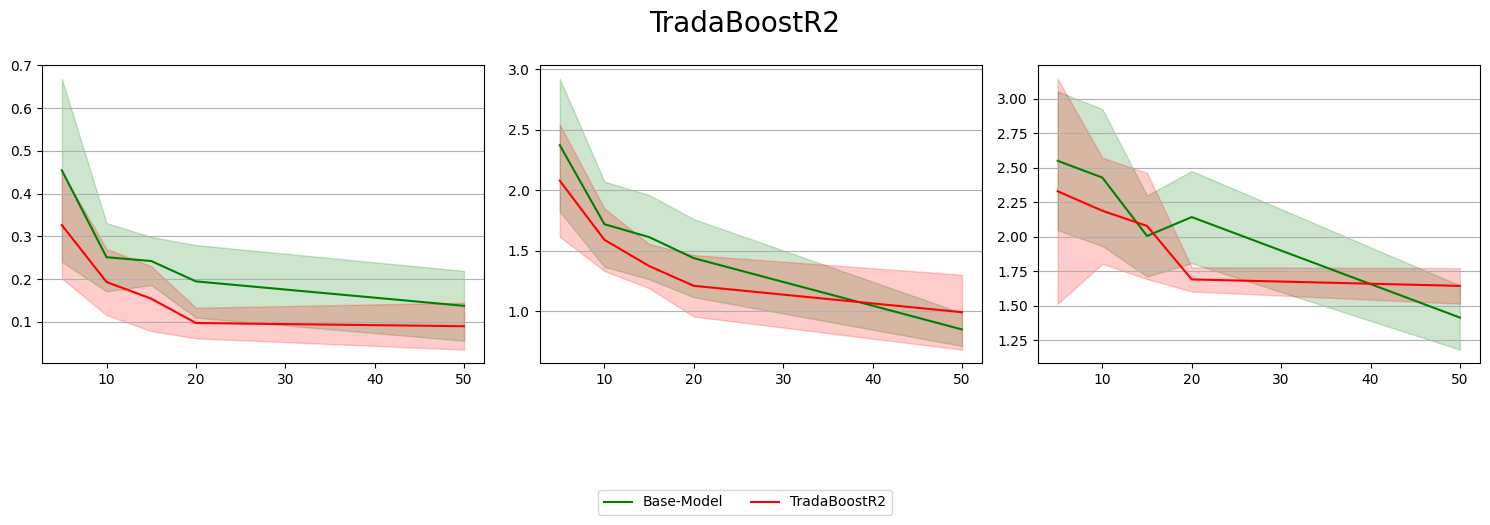

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("TradaBoostR2", fontsize=20)
speicherort_diagramme="build\\DIAGRAMME_PRAESI\\"
#========================================================================
#Standard Modell
#X MAE
prozente = [5, 10, 15, 20, 50]
x_mae_upper_values = [0.668879, 0.331212, 0.298660, 0.279682, 0.219200]
x_mae_lower_values = [0.240284, 0.171216, 0.185980, 0.109728, 0.055671]
x_mae_mean_values  = [0.454582, 0.251214, 0.242320, 0.194705, 0.137435]
#Y MAE
prozente = [5, 10, 15, 20, 50]
y_mae_upper_values = [2.922360, 2.070843, 1.960314, 1.760613, 0.984506]
y_mae_lower_values = [1.823473, 1.366487, 1.263816, 1.115037, 0.711599]
y_mae_mean_values  = [2.372917, 1.718665, 1.612065, 1.437825, 0.848052] 
#Phi MAE
prozente = [5, 10, 15, 20, 50]
phi_mae_upper_values = [3.053156, 2.924598, 2.298257, 2.476446, 1.646387]
phi_mae_lower_values = [2.046840, 1.931982, 1.711781, 1.807508, 1.180802]
phi_mae_mean_values  = [2.549998, 2.428290, 2.005019, 2.141977, 1.413595]


# Farben definieren
standard_color = 'green'
# X MAE Plot
axes[0].plot(prozente, x_mae_mean_values, color=standard_color, label='Base-Model')
axes[0].fill_between(prozente, 
                     x_mae_lower_values, 
                     x_mae_upper_values, 
                     color=standard_color, alpha=0.2)

# Y MAE Plot
axes[1].plot(prozente, y_mae_mean_values, color=standard_color, label='Base-Model')
axes[1].fill_between(prozente, 
                     y_mae_lower_values, 
                     y_mae_upper_values, 
                     color=standard_color, alpha=0.2)

# Phi MAE Plot
axes[2].plot(prozente, phi_mae_mean_values, color=standard_color, label='Base-Model')
axes[2].fill_between(prozente, 
                     phi_mae_lower_values, 
                     phi_mae_upper_values, 
                     color=standard_color, alpha=0.2)

#========================================================================
#Plotten der Ergebnisse für TradaBoostR2
# Beispielhafte Prozentangaben (x-Achse)
prozentwerte = [5,5, 10,10, 15,15, 20,50]
prozentwerte = [5, 10,15,20,50]

# Leere Listen für Mittelwerte und Standardabweichungen
mean_x_list, mean_y_list, mean_Phi_list = [], [], []
std_x_list, std_y_list, std_Phi_list = [], [], []
#dateipfad_training_17="build\\tradaboost_model\\training_17_5Prozent_Realdaten"
#dateipfad_training_25="build\\tradaboost_model\\training_25_5Prozent_Realdaten_15Stueck"
#dateipfad_training_22="build\\tradaboost_model\\training_22_10Prozent_Realdaten"
#dateipfad_training_26="build\\tradaboost_model\\training_26_10Prozent_Realdaten_15Stueck"
#dateipfad_training_23="build\\tradaboost_model\\training_23_15Prozent_Realdaten"
#dateipfad_training_27="build\\tradaboost_model\\training_27_15Prozent_Realdaten_15Stueck"
dateipfad_5Prozent="build\\tradaboost_model\\Combined_Models_Update\\training_5Prozent_Realdaten"
dateipfad_10Prozent="build\\tradaboost_model\\Combined_Models_Update\\training_10Prozent_Realdaten"
dateipfad_15Prozent="build\\tradaboost_model\\Combined_Models_Update\\training_15Prozent_Realdaten"
dateipfad_training_18="build\\tradaboost_model\\training_18_20Prozent_Realdaten"
dateipfad_training_24="build\\tradaboost_model\\training_24_50Prozent_Realdaten"
# Werte sammeln
for i, (dateipfad, prozent) in enumerate(zip(
        #[dateipfad_training_17,dateipfad_training_25,dateipfad_training_22,dateipfad_training_26, dateipfad_training_23,dateipfad_training_27, dateipfad_training_18,dateipfad_training_24],
        [dateipfad_5Prozent,dateipfad_10Prozent,dateipfad_15Prozent, dateipfad_training_18,dateipfad_training_24],
        prozentwerte)):
    pass
    mae_werte_X, mae_werte_Y, mae_werte_Phi = auswertung_mae_kombiniert(ober_ordner=dateipfad, unterordner_list=[])
    speichere_mae_ergebnisse(mae_werte_X=mae_werte_X,mae_werte_Y=mae_werte_Y,mae_werte_Phi=mae_werte_Phi,ausgangsordner=dateipfad,ziel_ordner="build\\results-tradaBoostR2\\KeinOfset",prozent=prozent)
    
    std_x = np.std(mae_werte_X)
    std_y = np.std(mae_werte_Y)
    std_Phi = np.std(mae_werte_Phi)
    mean_x = np.mean(mae_werte_X)
    mean_y = np.mean(mae_werte_Y)
    mean_Phi = np.mean(mae_werte_Phi)

    mean_x_list.append(mean_x)
    mean_y_list.append(mean_y)
    mean_Phi_list.append(mean_Phi)

    std_x_list.append(std_x)
    std_y_list.append(std_y)
    std_Phi_list.append(std_Phi)

# Plotten
axes[0].plot(prozentwerte, mean_x_list, color='red', label='TradaBoostR2')
axes[0].fill_between(prozentwerte,
                     np.array(mean_x_list) - np.array(std_x_list),
                     np.array(mean_x_list) + np.array(std_x_list),
                     color='red', alpha=0.2)
axes[1].plot(prozentwerte, mean_y_list, color='red', label='Mean MAE Y')
axes[1].fill_between(prozentwerte,
                     np.array(mean_y_list) - np.array(std_y_list),
                     np.array(mean_y_list) + np.array(std_y_list),
                     color='red', alpha=0.2)
axes[2].plot(prozentwerte, mean_Phi_list, color='red', label='Mean MAE Phi')
axes[2].fill_between(prozentwerte,
                     np.array(mean_Phi_list) - np.array(std_Phi_list),
                     np.array(mean_Phi_list) + np.array(std_Phi_list),
                     color='red', alpha=0.2)
 
for ax in axes:
    ax.grid(True, which='both', axis='y')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
plt.show()
fig.savefig(f"{speicherort_diagramme}TradaBoostR2_vs_CNN.pdf")   # als PDF
fig.savefig(f"{speicherort_diagramme}TradaBoostR2_vs_CNN.svg")   # als SVG

## **Vergleich der Ergebnisse für unterschiedliche Ausgangsdatensätze**
TradaboostR2 durchführen für unterschiedliche Anteile von Realdaten in der Target Domain und unterschiedliche  
1. Source Realdaten, Target Realdaten (Training 14, 19, 20)
2. Source Sim Daten, Target Realdaten (Training 11, 17, 18)
3. Source Sim Daten offset, Target Realdaten (Training 10, 16, 15)

In [ ]:
#2
dateipfad_training_11="build\\tradaboost_model\\training_11_90bis1ProzentRealdaten"
process_training_11=process_all_results(dateipfad_training_11,trained_on_scaled_Labels=True,tradaboost_model=True)
ergebnisse_training_11=get_plottable_data(process_training_11)
#Experiment 18
dateipfad_training_18="build\\tradaboost_model\\training_18_20Prozent_Realdaten"
process_training_18=process_all_results(dateipfad_training_18,trained_on_scaled_Labels=True,tradaboost_model=True)
ergebnisse_training_18=get_plottable_data(process_training_18)
#Training 17
dateipfad_training_17="build\\tradaboost_model\\training_17_5Prozent_Realdaten"
process_training_17=process_all_results(dateipfad_training_17,trained_on_scaled_Labels=True,tradaboost_model=True)
ergebnisse_training_17=get_plottable_data(process_training_17)
#3
dateipfad_training_10="build\\tradaboost_model\\training_10_90bis1ProzentRealdaten"
process_training_10=process_all_results(dateipfad_training_10,trained_on_scaled_Labels=True,tradaboost_model=True)
ergebnisse_training_10=get_plottable_data(process_training_10)
#Experiment 16
dateipfad_training_16="build\\tradaboost_model\\training_16_20Prozent_Realdaten"
process_training_16=process_all_results(dateipfad_training_16,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_16=get_plottable_data(process_training_16)
#Experiment 15
dateipfad_training_15="build\\tradaboost_model\\Training_15_5Prozent_Realdaten"
process_training_15=process_all_results(dateipfad_training_15,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_15=get_plottable_data(process_training_15)
#Experiment 22
dateipfad_training_22="build\\tradaboost_model\\training_22_10Prozent_Realdaten"
process_training_22=process_all_results(dateipfad_training_22,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_22=get_plottable_data(process_training_22)

# CORAL 
dateipfad_training_CORAL_03="build\\tradaboost_model\\training_CORAL_03_Daten01Bis05"
process_training_CORAL_03=process_all_results(dateipfad_training_CORAL_03,trained_on_scaled_Labels=True,tradaboost_model=True)
ergebnisse_training_CORAL_03=get_plottable_data(process_training_CORAL_03)



In [ ]:
#Experiment 22
dateipfad_training_22="build\\tradaboost_model\\training_22_10Prozent_Realdaten"
process_training_22=process_all_results(dateipfad_training_22,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_22=get_plottable_data(process_training_22)
#Experiment 23
dateipfad_training_23="build\\tradaboost_model\\training_23_15Prozent_Realdaten"
process_training_23=process_all_results(dateipfad_training_23,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_23=get_plottable_data(process_training_23)
#Experiment 24
dateipfad_training_24="build\\tradaboost_model\\training_24_50Prozent_Realdaten"
process_training_24=process_all_results(dateipfad_training_24,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_24=get_plottable_data(process_training_24)


In [ ]:
#Experiment 25
dateipfad_training_25="build\\tradaboost_model\\training_25_5Prozent_Realdaten_15Stueck"
process_training_25=process_all_results(dateipfad_training_25,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_25=get_plottable_data(process_training_25)
#Experiment 26
dateipfad_training_26="build\\tradaboost_model\\training_26_10Prozent_Realdaten_15Stueck"
process_training_26=process_all_results(dateipfad_training_26,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_26=get_plottable_data(process_training_26)
#Experiment 27
dateipfad_training_27="build\\tradaboost_model\\training_27_15Prozent_Realdaten_15Stueck"
process_training_27=process_all_results(dateipfad_training_27,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_27=get_plottable_data(process_training_27)


In [13]:
#Experiment 5%
dateipfad_training_5Prozent="build\\tradaboost_model\\Combined_Models_Update\\training_5Prozent_Realdaten"
process_training_5Prozent=process_all_results(dateipfad_training_5Prozent,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_5Prozent=get_plottable_data(process_training_5Prozent)
#Experiment 10%
dateipfad_training_10Prozent="build\\tradaboost_model\\Combined_Models_Update\\training_10Prozent_Realdaten"
process_training_10Prozent=process_all_results(dateipfad_training_10Prozent,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_10Prozent=get_plottable_data(process_training_10Prozent)
#Experiment 15%
dateipfad_training_15Prozent="build\\tradaboost_model\\Combined_Models_Update\\training_15Prozent_Realdaten"
process_training_15Prozent=process_all_results(dateipfad_training_15Prozent,trained_on_scaled_Labels=None,tradaboost_model=True)
ergebnisse_training_15Prozent=get_plottable_data(process_training_15Prozent)

Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_01
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_01\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867781\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_02
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_02\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867799\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_03
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_03\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867816\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_04
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_04\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867834\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 948us/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_05
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_05\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867850\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_06
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_06\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867868\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_07
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_07\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867885\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_08
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_08\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867902\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_09
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_09\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867918\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 989us/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_10
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_10\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867934\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_11
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_11\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867956\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_12
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_12\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867974\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_13
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_13\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745867991\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_14
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_14\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745868009\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_15
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\tarining_25_15\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random_N15\1745868027\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\training_17_01
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\training_17_01\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random\1744301857\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\training_17_02
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\training_17_02\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random\1744301869\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\training_17_03
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\training_17_03\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random\1744301887\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\training_17_04
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\training_17_04\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random\1744301902\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\training_17_05
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_5Prozent_Realdaten\training_17_05\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_5Prozent_Random\1744301919\
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_22_01
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_22_01\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random\1744636351\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_22_02
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_22_02\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random\1744636365\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 970us/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_22_03
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_22_03\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random\1744636380\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_22_04
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_22_04\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random\1744636398\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_22_05
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_22_05\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random\1744636416\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 991us/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_01
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_01\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746020954\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_02
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_02\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746020971\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_03
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_03\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746020989\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_04
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_04\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021007\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_05
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_05\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021022\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_06
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_06\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021039\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_07
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_07\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021055\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_08
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_08\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021072\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_09
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_09\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021088\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_10
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_10\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021106\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_11
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_11\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021125\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_12
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_12\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021143\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_13
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_13\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021166\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_14
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_14\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021184\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_15
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_10Prozent_Realdaten\tarining_26_15\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_10Prozent_Random_N15\1746021203\
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_23_01
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_23_01\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random\1744640173\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_23_02
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_23_02\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random\1744640190\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_23_03
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_23_03\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random\1744640210\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_23_04
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_23_04\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random\1744640233\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_23_05
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_23_05\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random\1744640254\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_01
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_01\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025339\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_02
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_02\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025355\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_03
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_03\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025372\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_04
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_04\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025389\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_05
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_05\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025407\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_06
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_06\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025424\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_07
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_07\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025443\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_08
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_08\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025460\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_09
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_09\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025477\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_10
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_10\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025495\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_11
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_11\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025513\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_12
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_12\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025531\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 3s 939us/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_13
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_13\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025549\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_14
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_14\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025566\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Subfolder: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_15
Einlesen des Modells: build\tradaboost_model\Combined_Models_Update\training_15Prozent_Realdaten\tarining_27_15\best_model.h5


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Einlesen der Scaler: build\window_split\real-data\Realdaten_15Prozent_Random_N15\1746025584\
3413/3413 ━━━━━━━━━━━━━━━━━━━━ 3s 951us/step


In [ ]:
#Plotten
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("TradaBoostR2", fontsize=20)

#Basismodelle 
daten_cnn_80='build\\results-base-model\\80\\'
fig, axes = plotten_Boxplots_MAE(averages_path=daten_cnn_80+"averages.json",label="CNN 80% Realdaten", color="grey",std_path=daten_cnn_80+"std.json",x_position=80,
                                 dataframe_path=daten_cnn_80+"dataframe.json",fig=fig,axes=axes,show_lines=False,show_box_plot=True)
daten_cnn_50='build\\results-base-model\\50\\'
fig, axes = plotten_Boxplots_MAE(averages_path=daten_cnn_50+"averages.json",label="CNN 80% Realdaten", color="grey",std_path=daten_cnn_50+"std.json",x_position=50,
                                 dataframe_path=daten_cnn_50+"dataframe.json",fig=fig,axes=axes,show_lines=False,show_box_plot=True)
daten_cnn_20='build\\results-base-model\\20\\'
fig, axes = plotten_Boxplots_MAE(averages_path=daten_cnn_20+"averages.json",label="CNN 80% Realdaten", color="black",std_path=daten_cnn_20+"std.json",x_position=20,
                                 dataframe_path=daten_cnn_20+"dataframe.json",fig=fig,axes=axes,show_lines=False,show_box_plot=True)
daten_cnn_10='build\\results-base-model\\10\\'
fig, axes = plotten_Boxplots_MAE(averages_path=daten_cnn_10+"averages.json",label="CNN 80% Realdaten", color="black",std_path=daten_cnn_10+"std.json",x_position=10,
                                 dataframe_path=daten_cnn_10+"dataframe.json",fig=fig,axes=axes,show_lines=False,show_box_plot=True)
daten_cnn_5='build\\results-base-model\\5\\'
fig, axes = plotten_Boxplots_MAE(averages_path=daten_cnn_5+"averages.json",label="CNN 80% Realdaten", color="black",std_path=daten_cnn_5+"std.json",x_position=5,
                                 dataframe_path=daten_cnn_5+"dataframe.json",fig=fig,axes=axes,show_lines=False,show_box_plot=True)

#Referenz TradaBoostR2
fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnisse_training_14,label="Source und Targetdaomin Realdaten",ergebnisart="Not scaled",
                                          overwrite_x_tics=[80,60,40,20,10,5][::-1],color="black",marker="*",fig=fig,axes=axes)
fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnisse_training_19,label=None,ergebnisart="Not scaled",
                                          overwrite_x_tics=[5,5,5,5,5][::-1],color="black",marker="*",fig=fig,axes=axes)
fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnisse_training_20,label=None,ergebnisart="Not scaled",
                                          overwrite_x_tics=[20,20,20,20,20][::-1],color="black",marker="*",fig=fig,axes=axes)
fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnisse_training_21,label=None,ergebnisart="Not scaled",
                                          overwrite_x_tics=[40,40,40,40,40,40][::-1],color="black",marker="*",fig=fig,axes=axes)

for i,(ergebnis,prozente) in enumerate(zip([ergebnisse_training_11, ergebnisse_training_18,ergebnisse_training_17,ergebnisse_training_22,ergebnisse_training_23],
                             [[90,80,70,60,50,40,30,20,10,7,5,3,1][::-1],[20,20,20,20,20],[5,5,5,5,5,],[10,10,10,10,10],[15,15,15,15,15]])):
    if not i==0:
       fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnis,label="Kein Ofset, scaled labels" if i==1 else None,ergebnisart="Not scaled",
                                                overwrite_x_tics=prozente,color="blue",marker="4",fig=fig,axes=axes)
    else:
        fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnis,label="Kein Ofset, scaled labels, Einzelversuche" if i==0 else None,ergebnisart="Not scaled",
                                            overwrite_x_tics=prozente,color="green",marker="4",fig=fig,axes=axes)

'''
for i, (ergebnis,prozente) in enumerate(zip([ergebnisse_training_10, ergebnisse_training_16,ergebnisse_training_15],
                             [[90,80,70,60,50,40,30,20,10,7,5,3,1][::-1],[20,20,20,20,20],[5,5,5,5,5,]])):
    fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnis,label="Ofset multiplitiv, scaled labels" if i==0 else None,ergebnisart="Not scaled",
                                              overwrite_x_tics=[90,80,70,60,50,40,30,20,10,7,5,3,1][::-1],color="red",marker="2",fig=fig,axes=axes)

#TradaBoostR2 mit CORAL
fig, axes=plotten_TradaBoostR2_Ergebnisse_MAE(ergebnisse_training_CORAL_03,label="CORAL Sim Daten, Lbels Scaled",ergebnisart="Not scaled",
                                          overwrite_x_tics=[20,20,20,20,20],color="red",marker="D",fig=fig,axes=axes)
'''
for ax in axes:
    ax.grid(True, which='both', axis='y')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
plt.show()

Konfidenzintervalle Bei 5 bis 20%
-> Standardabweichung und Mittelwert

Basismodell
Einzelergebnis: 80%


NameError: name 'plotten_Boxplots_MAE' is not defined

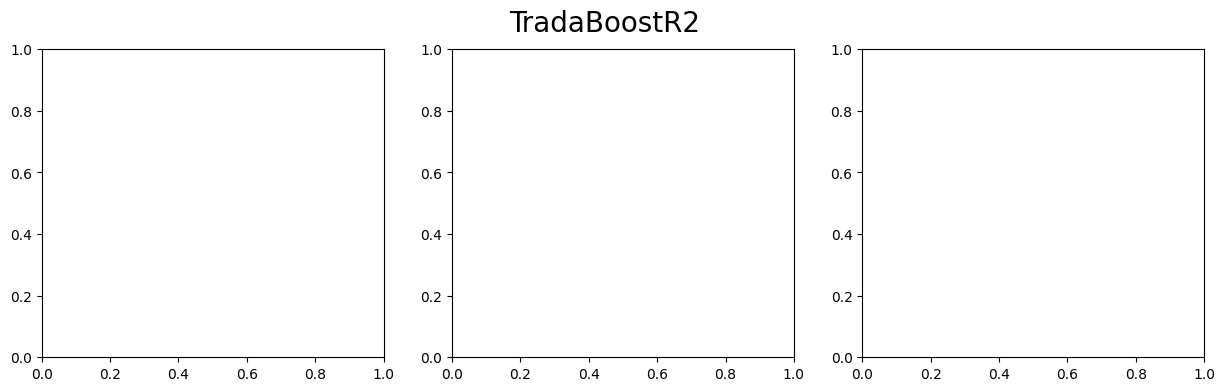

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("TradaBoostR2", fontsize=20)

#Basismodelle 
print("Basismodell")
print("Einzelergebnis: 80%")
daten_cnn_80='build\\results-base-model\\80\\'
fig, axes = plotten_Boxplots_MAE(averages_path=daten_cnn_80+"averages.json",label="CNN 80% Realdaten", color="grey",std_path=daten_cnn_80+"std.json",x_position=80,
                                 dataframe_path=daten_cnn_80+"dataframe.json",fig=fig,axes=axes,show_lines=False,show_box_plot=True)
print("Einzelergebnis: 50%")
daten_cnn_50='build\\results-base-model\\50\\'
fig, axes = plotten_Boxplots_MAE(averages_path=daten_cnn_50+"averages.json",label="CNN 80% Realdaten", color="grey",std_path=daten_cnn_50+"std.json",x_position=50,
                                 dataframe_path=daten_cnn_50+"dataframe.json",fig=fig,axes=axes,show_lines=False,show_box_plot=True)
print("Einzelergebnis: 20%")
daten_cnn_20='build\\results-base-model\\20\\'
fig, axes = plotten_Boxplots_MAE(averages_path=daten_cnn_20+"averages.json",label="CNN 80% Realdaten", color="black",std_path=daten_cnn_20+"std.json",x_position=20,
                                 dataframe_path=daten_cnn_20+"dataframe.json",fig=fig,axes=axes,show_lines=False,show_box_plot=True)
print("Einzelergebnis: 10%")
daten_cnn_10='build\\results-base-model\\10\\'
fig, axes = plotten_Boxplots_MAE(averages_path=daten_cnn_10+"averages.json",label="CNN 80% Realdaten", color="black",std_path=daten_cnn_10+"std.json",x_position=10,
                                 dataframe_path=daten_cnn_10+"dataframe.json",fig=fig,axes=axes,show_lines=False,show_box_plot=True)
print("Einzelergebnis: 5%")
daten_cnn_5='build\\results-base-model\\5\\'
fig, axes = plotten_Boxplots_MAE(averages_path=daten_cnn_5+"averages.json",label="CNN 80% Realdaten", color="black",std_path=daten_cnn_5+"std.json",x_position=5,
                              dataframe_path=daten_cnn_5+"dataframe.json",fig=fig,axes=axes,show_lines=False,show_box_plot=True)

# Beispielhafte Prozentangaben (x-Achse)
prozentwerte = [5, 10, 15, 20,50]

# Leere Listen für Mittelwerte und Standardabweichungen
mean_x_list, mean_y_list, mean_Phi_list = [], [], []
std_x_list, std_y_list, std_Phi_list = [], [], []

# Werte sammeln
for i, (dateipfad, prozent) in enumerate(zip(
        [dateipfad_training_17, dateipfad_training_22, dateipfad_training_23, dateipfad_training_18,dateipfad_training_24],
        prozentwerte)):
    pass
    mae_werte_X, mae_werte_Y, mae_werte_Phi = auswertung_mae_kombiniert(ober_ordner=dateipfad, unterordner_list=[])
    speichere_mae_ergebnisse(mae_werte_X=mae_werte_X,mae_werte_Y=mae_werte_Y,mae_werte_Phi=mae_werte_Phi,ausgangsordner=dateipfad,ziel_ordner="build\\results-tradaBoostR2\\KeinOfset",prozent=prozent)
    
    std_x = np.std(mae_werte_X)
    std_y = np.std(mae_werte_Y)
    std_Phi = np.std(mae_werte_Phi)
    mean_x = np.mean(mae_werte_X)
    mean_y = np.mean(mae_werte_Y)
    mean_Phi = np.mean(mae_werte_Phi)

    mean_x_list.append(mean_x)
    mean_y_list.append(mean_y)
    mean_Phi_list.append(mean_Phi)

    std_x_list.append(std_x)
    std_y_list.append(std_y)
    std_Phi_list.append(std_Phi)

# Plotten
#fig, axes = plt.subplots(1, 3, figsize=(15, 4))
#fig.suptitle("TradaBoostR2", fontsize=20)
print("TradaBostR2 Modell")
print("Verstellweg_X")
print(f"Prozente = {prozentwerte}")
print(f"Mittelwerte {mean_x_list}")
print(f"Standardabweichung ={std_x_list}")
axes[0].plot(prozentwerte, mean_x_list, color='red', label='TradaBoostR2')
axes[0].fill_between(prozentwerte,
                     np.array(mean_x_list) - np.array(std_x_list),
                     np.array(mean_x_list) + np.array(std_x_list),
                     color='red', alpha=0.2)

print("Verstellweg_Y")
print(f"Prozente = {prozentwerte}")
print(f"Mittelwerte {mean_y_list}")
print(f"Standardabweichung ={std_y_list}")
axes[1].plot(prozentwerte, mean_y_list, color='red', label='Mean MAE Y')
axes[1].fill_between(prozentwerte,
                     np.array(mean_y_list) - np.array(std_y_list),
                     np.array(mean_y_list) + np.array(std_y_list),
                     color='red', alpha=0.2)

# Verstellweg_Phi
print("Verstellweg_Phi")
print(f"Prozente = {prozentwerte}")
print(f"Mittelwerte {mean_Phi_list}")
print(f"Standardabweichung ={std_Phi_list}")
axes[2].plot(prozentwerte, mean_Phi_list, color='red', label='Mean MAE Phi')
axes[2].fill_between(prozentwerte,
                     np.array(mean_Phi_list) - np.array(std_Phi_list),
                     np.array(mean_Phi_list) + np.array(std_Phi_list),
                     color='red', alpha=0.2)
 
for ax in axes:
    ax.grid(True, which='both', axis='y')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3))
#plt.tight_layout()
plt.show()

Vergleich von Basismodellen:
- Target und Source Realdaten auf der Modellstruktur von Sim Daten Optimierung
- Fehler eintragen von konventieonellem Training auf Realen Daten mit der Modellstruktur von Sim Daten Optimierung

Box Plots: Vergleich von Tradaboost bei verscheidenen Sim Daten Offsets und CORAL

Box Plot für 20% Realdaten: 
- Basis Modell 
- Tradaboost auf Ausgangssimdaten 
- Tradaboost auf CORAL
- Harter Code weil Ergebnisse von Team mit eingebaut wurde

In [ ]:
#CNN Realdten
werte_cnn={"Verstellweg_Phi_mean_absolute_error":{
        "0":1.9067816734,
        "1":2.1337795258,
        "2":1.9199428558,
        "3":1.9067816734,
        "4":3.005964756,
        "5":1.9067816734,
        "6":2.2692170143
    },"Verstellweg_X_mean_absolute_error":{
        "0":0.209063977,
        "1":0.171160996,
        "2":0.1484249532,
        "3":0.209063977,
        "4":0.0717340857,
        "5":0.209063977,
        "6":0.3262635767
    },
    "Verstellweg_Y_mean_absolute_error":{
        "0":1.9697440863,
        "1":1.351219058,
        "2":1.1623004675,
        "3":1.9697440863,
        "4":1.1553333998,
        "5":1.9697440863,
        "6":1.4088890553
    }}
#Daten Tradaboost 20%
tradaBoostR2={"Verstellweg_X_mean_absolute_error": {
        "0": 0.12250337163710164,
        "1": 0.06145791206108678,
        "2": 0.15484200206590248,
        "3": 0.0786290246397835,
        "4": 0.06858963713414828
    },
    "Verstellweg_Y_mean_absolute_error": {
        "0": 0.8795664960824864,
        "1": 1.6466492937146229,
        "2": 1.2280335819845427,
        "3": 1.2285310542835002,
        "4": 1.0620621863674233
    },
    "Verstellweg_Phi_mean_absolute_error": {
        "0": 1.6013948748018372,
        "1": 1.5687989227375518,
        "2": 1.7783990885369756,
        "3": 1.76735358534929,
        "4": 1.735422802396724
    }
}
#Werte von Coral
tradaBoostR2_CORAL={
    "Verstellweg_X_mean_absolute_error": {
        "0": 0.08916666363060587,
        "1": 0.01441970658478481,
        "2": 0.2845787332813527,
        "3": 0.058659423202674664,
        "4": 0.025058066611856136
    },
    "Verstellweg_Y_mean_absolute_error": {
        "0": 1.2076558100259316,
        "1": 1.152666684863061,
        "2": 1.191035593494967,
        "3": 1.1321671400178104,
        "4": 1.0151379487677
    },
    "Verstellweg_Phi_mean_absolute_error": {
        "0": 2.741374029036908,
        "1": 2.361319938769061,
        "2": 1.9479067650002413,
        "3": 2.0183503363440707,
        "4": 1.6194910031975571
    }
}
#Daten zu Sorft Start, 20% Realdaten
soft_start_daten={
        "Verstellweg_Phi_mean_absolute_error":{
        "0":1.8479813337,
        "1":1.9301689863,
        "2":1.4882190228,
        "3":1.4696961641,
        "4":1.4983427525
    },
    "Verstellweg_X_mean_absolute_error":{
        "0":0.063426502,
        "1":0.0344519727,
        "2":0.1150183976,
        "3":0.1496070921,
        "4":0.0980957523
    },
    "Verstellweg_Y_mean_absolute_error":{
        "0":1.1159968376,
        "1":1.424552083,
        "2":0.8680146337,
        "3":1.6187688112,
        "4":1.1865266562
    }
}

def extract_values(data, key):
    return list(data[key].values())

# Verstellwege und Labels
verstellwege = [
    ("Verstellweg_X_mean_absolute_error", "Verstellweg X"),
    ("Verstellweg_Y_mean_absolute_error", "Verstellweg Y"),
    ("Verstellweg_Phi_mean_absolute_error", "Verstellweg Phi")
]
from matplotlib.patches import Patch
# Plot Setup
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
#fig.suptitle("MAE der Verstellwege bei 20% der Realdaten", fontsize=20)

titel_formeln = [r"$x$", r"$y$", r"$\varphi$"]
# Farbliche Gestaltung
farben = ['#1f77b4', '#2ca02c', '#ff7f0e']
farben=['#005AA9','#005AA9','#005AA9']
farben=["green","red","orange","blue"]# TODO hier ergänzen 
farben=["grey","grey","grey","grey"]# TODO hier ergänzen 
schraffuren = ['///', '\\\\\\', '|||', 'xxx']
methoden = ["Base-Model", "TrAdaBoostR2", "TrAdaBoostR2-CORAL", "Fine-Tuning"]
# Für jeden Verstellweg die Boxplots einzeichnen
for i,(ax, (verstellweg_key, verstellweg_label)) in enumerate(zip(axes, verstellwege)):
    # Werte extrahieren
    cnn_values = extract_values(werte_cnn, verstellweg_key)
    trada_values = extract_values(tradaBoostR2, verstellweg_key)
    coral_values = extract_values(tradaBoostR2_CORAL, verstellweg_key)
    soft_start_values= extract_values(soft_start_daten, verstellweg_key)

    # Boxplots zeichnen
    bp = ax.boxplot([cnn_values, trada_values, coral_values,soft_start_values],
                    #labels=["CNN", "TrAdaBoostR2", "TrAdaBoostR2_CORAL","Softstart"],
                    patch_artist=True,
                    widths=0.6)
    
    for patch, hatch in zip(bp['boxes'], schraffuren):
        patch.set(hatch=hatch, facecolor='white', edgecolor='black', linewidth=1.5)

    
    y_min = min(min(cnn_values), min(trada_values), min(coral_values), min(soft_start_values))
    ax.set_ylim(bottom=y_min - 0.05)  # Optional: Ein kleiner Offset nach unten, um Platz zu schaffen


    # Farben zuweisen
    for patch, color in zip(bp['boxes'], farben):
        patch.set_facecolor(color)

    # Mediane hervorheben
    for median in bp['medians']:
        median.set(color='black', linewidth=2)
    mae_addon=["x","y","\varphi"]
    if i==0:
        ax.set_ylabel(f"$MAE_x$ [mm]",fontsize=20)
    elif i==1:
        ax.set_ylabel(f"$MAE_y$ [mm]",fontsize=20)
    else:
        ax.set_ylabel("$MAE_{\\varphi}$ [°]",fontsize=20)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xticks([])
    #ax.set_title(f"Diviation $\Delta${titel_formeln[i]}", fontsize=18)
    #ax.set_ylabel("Mean Absolute Error")
    ax.grid(True, linestyle='--', alpha=0.6)
    #ax.set_ylim(bottom=0)  # Damit die Boxen immer bei 0 starten

legenden_patches = [Patch(facecolor='grey', hatch=h, edgecolor='black', label=label) 
                    for h, label in zip(schraffuren, methoden)]
fig.legend(handles=legenden_patches, loc='lower center', ncol=4, fontsize=24, frameon=False, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.show()

fig.savefig(f"{speicherort_diagramme}BoxPlot_3Modelle.pdf")   # als PDF
fig.savefig(f"{speicherort_diagramme}BoxPlot_3Modelle.svg")   # als SVG



In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def extract_values(data, key):
    return list(data[key].values())

# Verstellwege und Labels
verstellwege = [
    ("Verstellweg_X_mean_absolute_error", "Verstellweg X", r"$MAE_x$ [mm]"),
    ("Verstellweg_Y_mean_absolute_error", "Verstellweg Y", r"$MAE_y$ [mm]"),
    ("Verstellweg_Phi_mean_absolute_error", "Verstellweg Phi", r"$MAE_{\varphi}$ [°]")
]

# Farben und Schraffuren
farben = ["white", "white", "white", "white"]
schraffuren = ['///', '\\\\\\', '|||', 'xxx']
methoden = ["Base-Model", "TrAdaBoostR2", "TrAdaBoostR2-CORAL", "Fine-Tuning"]

speicherort_diagramme="build\\DIAGRAMME_PRAESI\\"


# Boxplots zeichnen ohne Legenden
for verstellweg_key, verstellweg_label, ylabel in verstellwege:
    fig, ax = plt.subplots(figsize=(4,3))

    # Werte extrahieren
    cnn_values = extract_values(werte_cnn, verstellweg_key)
    trada_values = extract_values(tradaBoostR2, verstellweg_key)
    coral_values = extract_values(tradaBoostR2_CORAL, verstellweg_key)
    soft_start_values = extract_values(soft_start_daten, verstellweg_key)

    # Boxplot zeichnen
    bp = ax.boxplot([cnn_values, trada_values, coral_values, soft_start_values],
                    patch_artist=True, widths=0.6)

    for patch, hatch, color in zip(bp['boxes'], schraffuren, farben):
        patch.set(hatch=hatch, facecolor=color, edgecolor='black', linewidth=1.5)

    # Mediane
    for median in bp['medians']:
        median.set(color='black', linewidth=2)

    # Y-Achse
    y_min = min(min(cnn_values), min(trada_values), min(coral_values), min(soft_start_values))
    ax.set_ylim(bottom=y_min - 0.05)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xticks([])
    ax.set_box_aspect(3/4)
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    # Dateiname bauen
    name_suffix = verstellweg_label.replace(" ", "_")
    fig.savefig(f"{speicherort_diagramme}BoxPlot_{name_suffix}.pdf")
    fig.savefig(f"{speicherort_diagramme}BoxPlot_{name_suffix}.svg")

    #plt.close(fig)


# Neue Figure für Legende
fig_legend, ax_legend = plt.subplots(figsize=(4, 4))  # Etwas größer für den Rand

# Dummy-Patches für Legende
legenden_patches = [Patch(facecolor='white', hatch=h, edgecolor='black', label=label) 
                    for h, label in zip(schraffuren, methoden)]

# Legende zentriert im Plot platzieren
ax_legend.legend(handles=legenden_patches, 
                 loc='center', 
                 fontsize=18, 
                 frameon=False)

# Achsen ausblenden
ax_legend.axis('off')

# 0.5 cm (~0.2 inch) Rand um die Figure herum
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)

# Speichern
fig_legend.savefig(f"{speicherort_diagramme}BoxPlot_Legende_Mitte.pdf", bbox_inches='tight', pad_inches=0.5/2.54)
fig_legend.savefig(f"{speicherort_diagramme}BoxPlot_Legende_Mitte.svg", bbox_inches='tight', pad_inches=0.5/2.54)

#plt.close(fig_legend)


In [ ]:
#CNN Realdten
werte_cnn={"Verstellweg_Phi_mean_absolute_error":{
        "0":1.9067816734,
        "1":2.1337795258,
        "2":1.9199428558,
        "3":1.9067816734,
        "4":3.005964756,
        "5":1.9067816734,
        "6":2.2692170143
    },"Verstellweg_X_mean_absolute_error":{
        "0":0.209063977,
        "1":0.171160996,
        "2":0.1484249532,
        "3":0.209063977,
        "4":0.0717340857,
        "5":0.209063977,
        "6":0.3262635767
    },
    "Verstellweg_Y_mean_absolute_error":{
        "0":1.9697440863,
        "1":1.351219058,
        "2":1.1623004675,
        "3":1.9697440863,
        "4":1.1553333998,
        "5":1.9697440863,
        "6":1.4088890553
    }}
#Daten Tradaboost 20%
tradaBoostR2={"Verstellweg_X_mean_absolute_error": {
        "0": 0.12250337163710164,
        "1": 0.06145791206108678,
        "2": 0.15484200206590248,
        "3": 0.0786290246397835,
        "4": 0.06858963713414828
    },
    "Verstellweg_Y_mean_absolute_error": {
        "0": 0.8795664960824864,
        "1": 1.6466492937146229,
        "2": 1.2280335819845427,
        "3": 1.2285310542835002,
        "4": 1.0620621863674233
    },
    "Verstellweg_Phi_mean_absolute_error": {
        "0": 1.6013948748018372,
        "1": 1.5687989227375518,
        "2": 1.7783990885369756,
        "3": 1.76735358534929,
        "4": 1.735422802396724
    }
}
#Werte von Coral
tradaBoostR2_CORAL={
    "Verstellweg_X_mean_absolute_error": {
        "0": 0.08916666363060587,
        "1": 0.01441970658478481,
        "2": 0.2845787332813527,
        "3": 0.058659423202674664,
        "4": 0.025058066611856136
    },
    "Verstellweg_Y_mean_absolute_error": {
        "0": 1.2076558100259316,
        "1": 1.152666684863061,
        "2": 1.191035593494967,
        "3": 1.1321671400178104,
        "4": 1.0151379487677
    },
    "Verstellweg_Phi_mean_absolute_error": {
        "0": 2.741374029036908,
        "1": 2.361319938769061,
        "2": 1.9479067650002413,
        "3": 2.0183503363440707,
        "4": 1.6194910031975571
    }
}
#Daten zu Sorft Start, 20% Realdaten
soft_start_daten={
        "Verstellweg_Phi_mean_absolute_error":{
        "0":1.8479813337,
        "1":1.9301689863,
        "2":1.4882190228,
        "3":1.4696961641,
        "4":1.4983427525
    },
    "Verstellweg_X_mean_absolute_error":{
        "0":0.063426502,
        "1":0.0344519727,
        "2":0.1150183976,
        "3":0.1496070921,
        "4":0.0980957523
    },
    "Verstellweg_Y_mean_absolute_error":{
        "0":1.1159968376,
        "1":1.424552083,
        "2":0.8680146337,
        "3":1.6187688112,
        "4":1.1865266562
    }
}

def extract_values(data, key):
    return list(data[key].values())

# Verstellwege und Labels
verstellwege = [
    ("Verstellweg_X_mean_absolute_error", "Verstellweg X"),
    ("Verstellweg_Y_mean_absolute_error", "Verstellweg Y"),
    ("Verstellweg_Phi_mean_absolute_error", "Verstellweg Phi")
]
from matplotlib.patches import Patch
# Plot Setup
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
#fig.suptitle("MAE der Verstellwege bei 20% der Realdaten", fontsize=20)

titel_formeln = [r"$x$", r"$y$", r"$\varphi$"]
# Farbliche Gestaltung
farben=["green","red","orange","blue"]# TODO hier ergänzen 
methoden = ["Base-Model", "TrAdaBoostR2", "TrAdaBoostR2-CORAL", "Fine-Tuning"]
# Für jeden Verstellweg die Boxplots einzeichnen
for i,(ax, (verstellweg_key, verstellweg_label)) in enumerate(zip(axes, verstellwege)):
    # Werte extrahieren
    cnn_values = extract_values(werte_cnn, verstellweg_key)
    trada_values = extract_values(tradaBoostR2, verstellweg_key)
    coral_values = extract_values(tradaBoostR2_CORAL, verstellweg_key)
    soft_start_values= extract_values(soft_start_daten, verstellweg_key)

    # Boxplots zeichnen
    bp = ax.boxplot([cnn_values, trada_values, coral_values,soft_start_values],
                    labels=["CNN", "TrAdaBoostR2", "TrAdaBoostR2_CORAL","Softstart"],
                    patch_artist=True,
                    widths=0.6)
    
    
    
    y_min = min(min(cnn_values), min(trada_values), min(coral_values), min(soft_start_values))
    ax.set_ylim(bottom=y_min - 0.05)  # Optional: Ein kleiner Offset nach unten, um Platz zu schaffen


    # Farben zuweisen
    for patch, color in zip(bp['boxes'], farben):
        patch.set_facecolor(color)

    # Mediane hervorheben
    for median in bp['medians']:
        median.set(color='black', linewidth=2)

    if i < 2:
        ax.set_ylabel("MAE [mm]",fontsize=14)
    else:
        ax.set_ylabel("MAE [°]",fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=0)
    
    ax.set_title(f"Verstellweg $\Delta${titel_formeln[i]}", fontsize=18)
    #ax.set_ylabel("Mean Absolute Error")
    ax.grid(True, linestyle='--', alpha=0.6)
    #ax.set_ylim(bottom=0)  # Damit die Boxen immer bei 0 starten


plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.show()

fig.savefig(f"{speicherort_diagramme}BoxPlot_3Modelle_bunt.pdf")   # als PDF
fig.savefig(f"{speicherort_diagramme}BoxPlot_3Modelle_bunt.svg")   # als SVG



In [ ]:
for i, (dateipfad, prozent) in enumerate(zip(
        [dateipfad_training_CORAL_03],
        [20])):
    pass
    mae_werte_X, mae_werte_Y, mae_werte_Phi = auswertung_mae_kombiniert(ober_ordner=dateipfad, unterordner_list=[])
    speichere_mae_ergebnisse(mae_werte_X=mae_werte_X,mae_werte_Y=mae_werte_Y,mae_werte_Phi=mae_werte_Phi,ausgangsordner=dateipfad,
                             ziel_ordner="build\\results-tradaBoostR2\\CORAL_03",prozent=prozent)

#ergebnisse_training_CORAL_03